# Neural Networks

In this notebook, we will use neural networks to predict time series data. Traditional models, such as decision trees, provided valuable insights. Now, the objective is to use different network structures and tune parameters to improve the precision when predicting wind turbine power output.

First let's import our EDA and preprocessing.

importing Jupyter notebook from EDA_Preprocessing.ipynb
Number of Features:  21
Number of Entries:  208910
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208910 entries, 0 to 208909
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   active_power            208910 non-null  float64
 1   timestamp               208910 non-null  object 
 2   pitch_angle             208910 non-null  float64
 3   reactive_power          208910 non-null  float64
 4   nacelle_angle           208910 non-null  float64
 5   nacelle_temp            208910 non-null  float64
 6   wind_speed1             208910 non-null  float64
 7   wind_speed2             208910 non-null  float64
 8   wind_speed_avg          208910 non-null  float64
 9   wind_angle              208910 non-null  float64
 10  vane_angle              208910 non-null  float64
 11  outdoor_temp            208910 non-null  float64
 12  rotor_angular_velocit

<IPython.core.display.Javascript object>


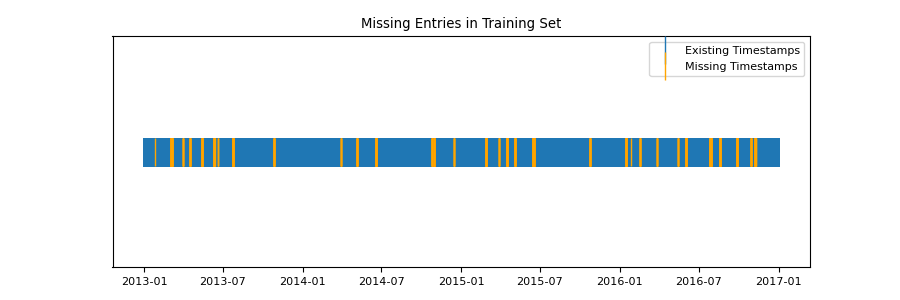

Tuesday      326
Monday       287
Wednesday    279
Friday       204
Thursday     187
Sunday        73
Name: count, dtype: int64
Number of entries on holidays: 0


<IPython.core.display.Javascript object>


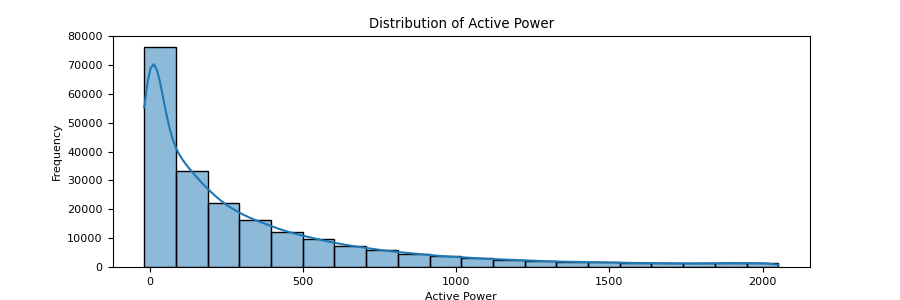

<IPython.core.display.Javascript object>


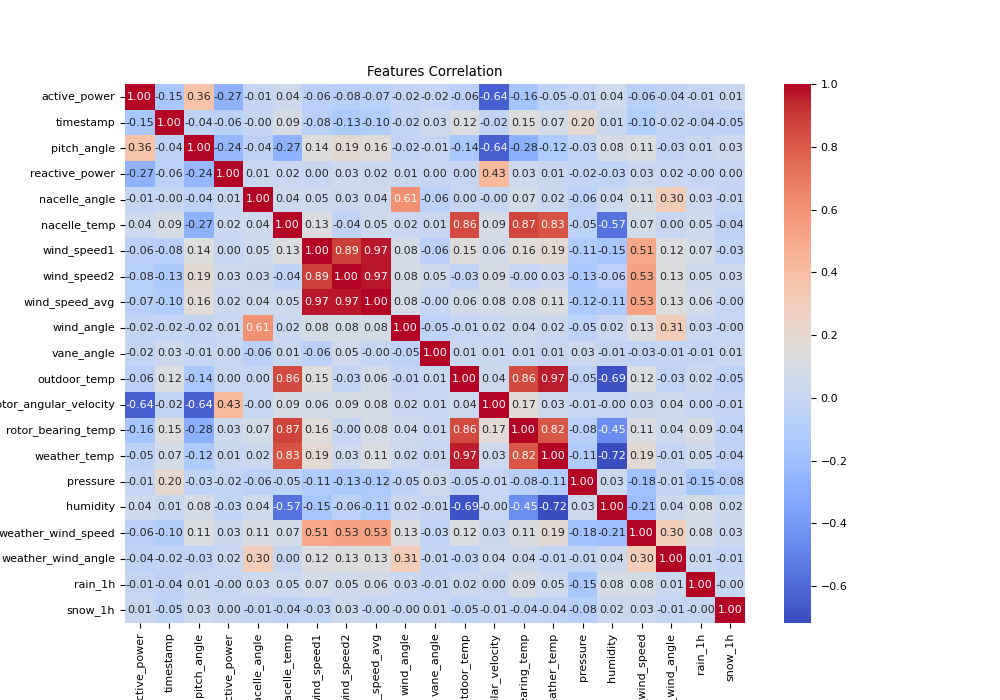

<IPython.core.display.Javascript object>


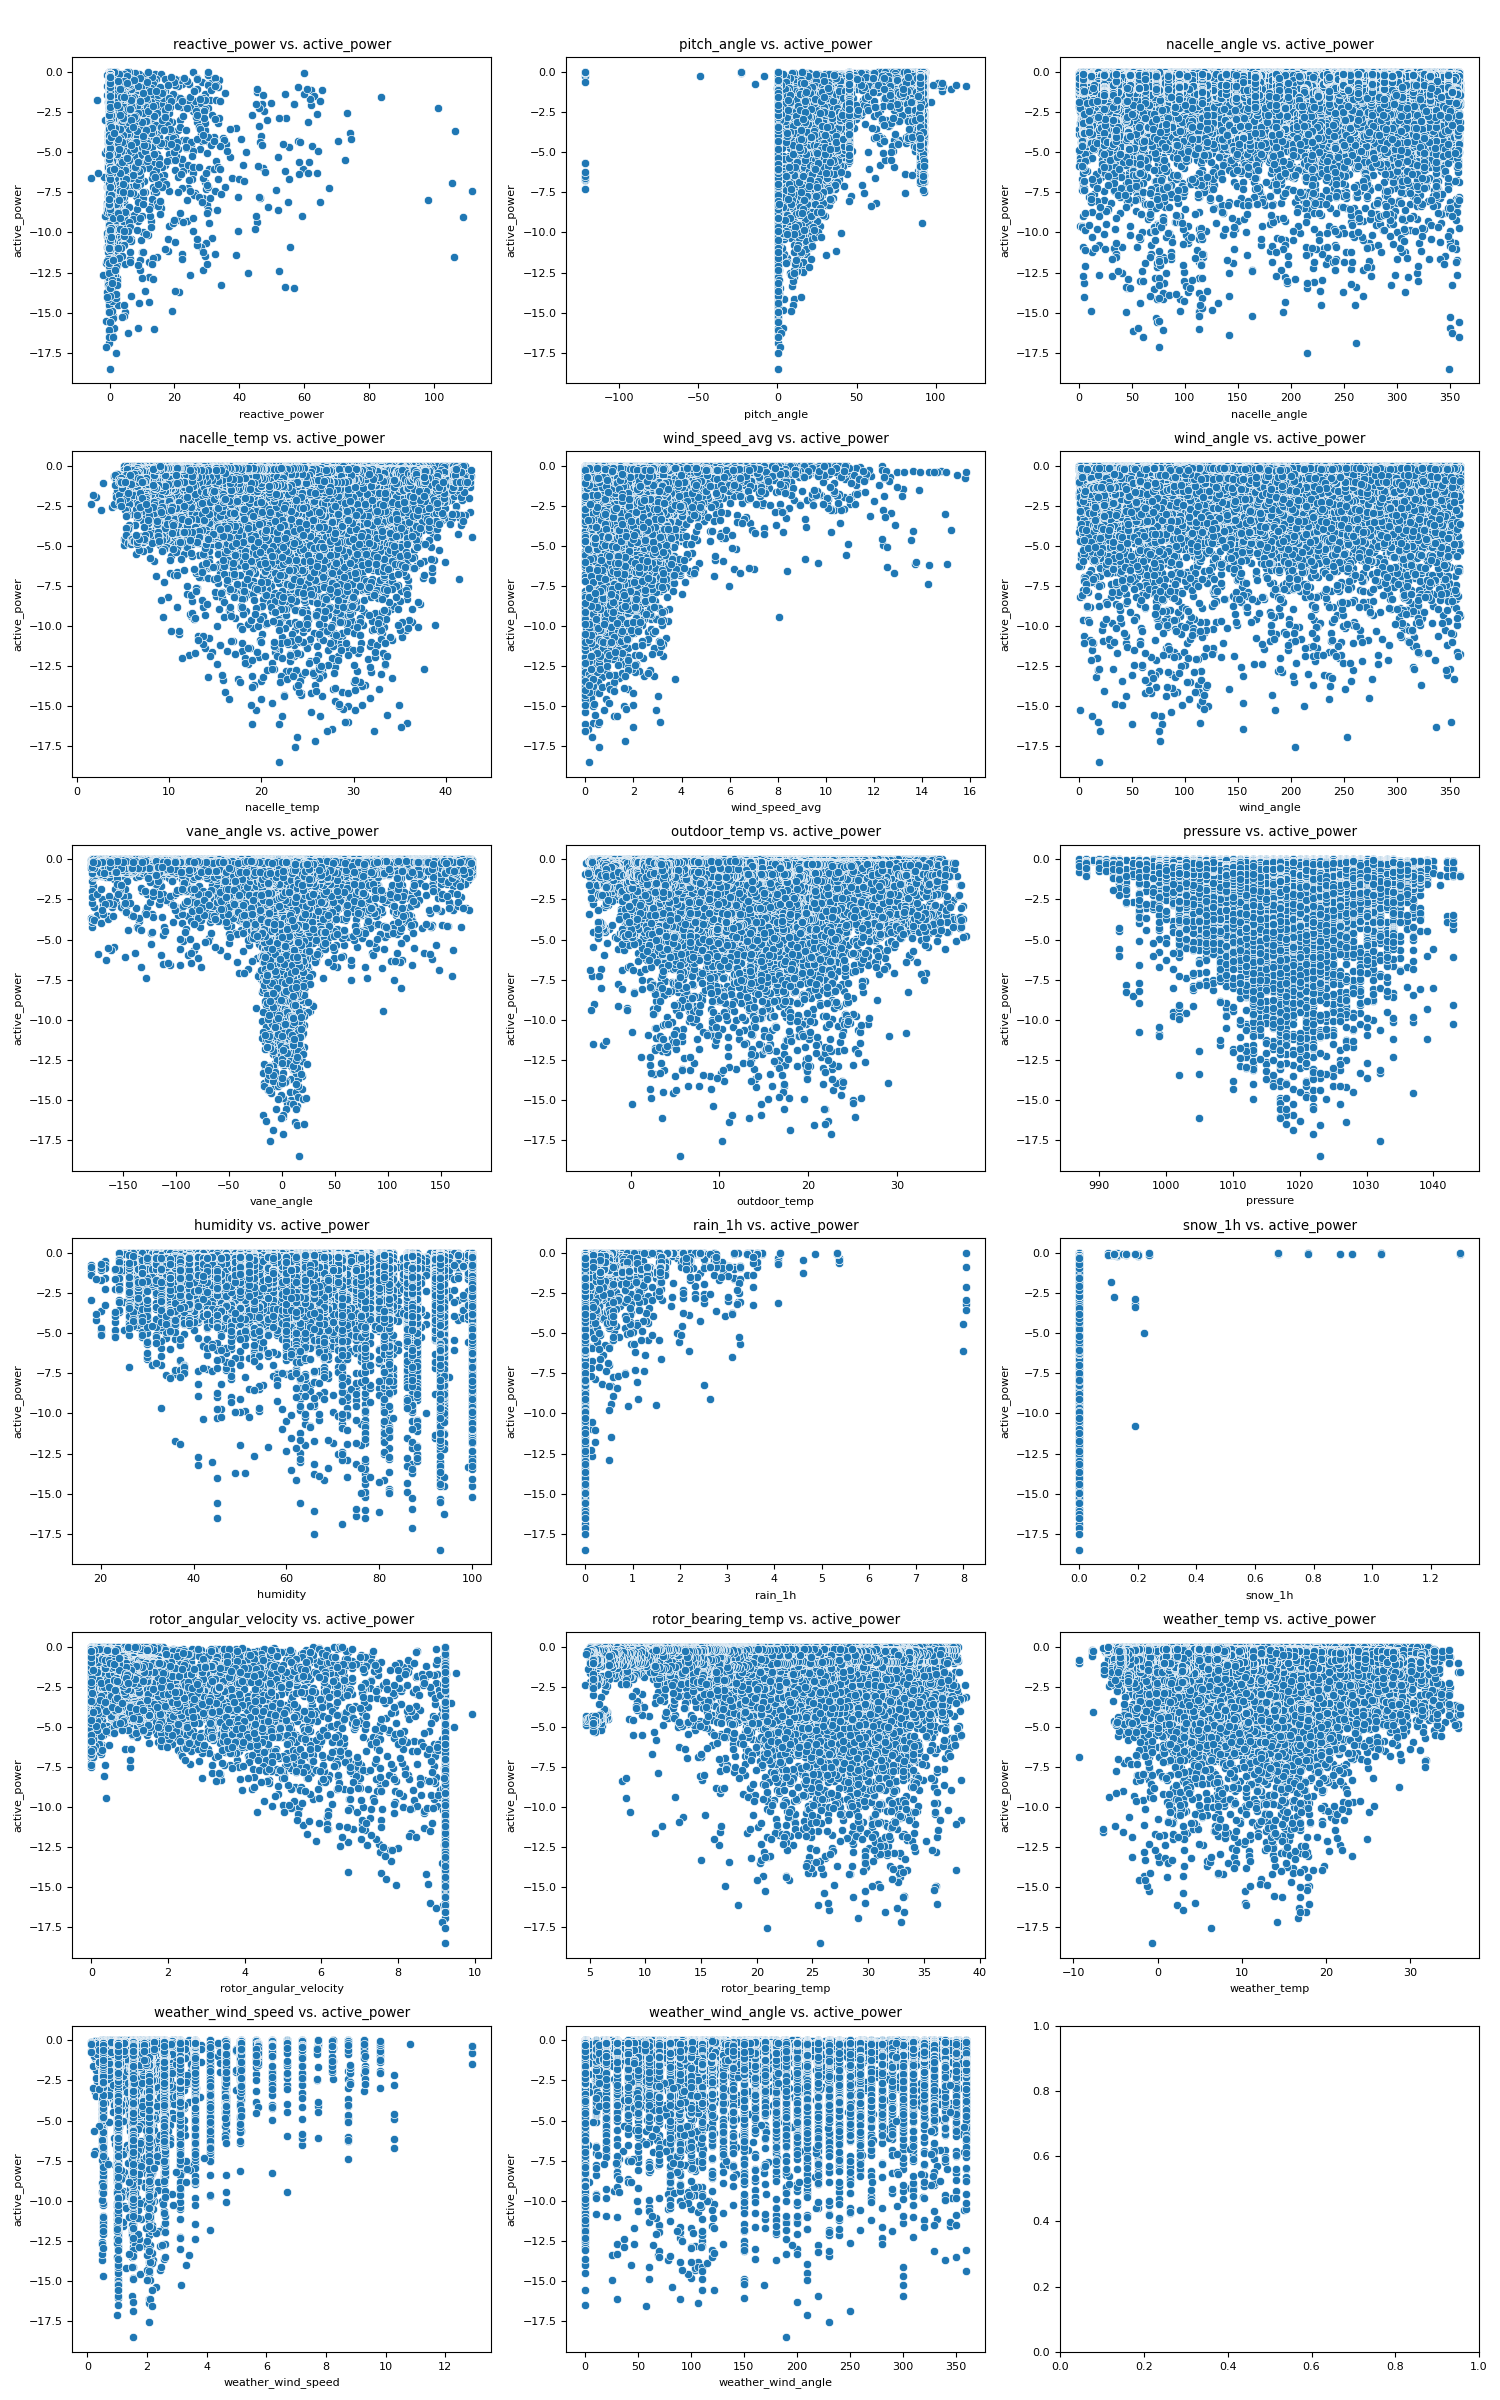

<IPython.core.display.Javascript object>


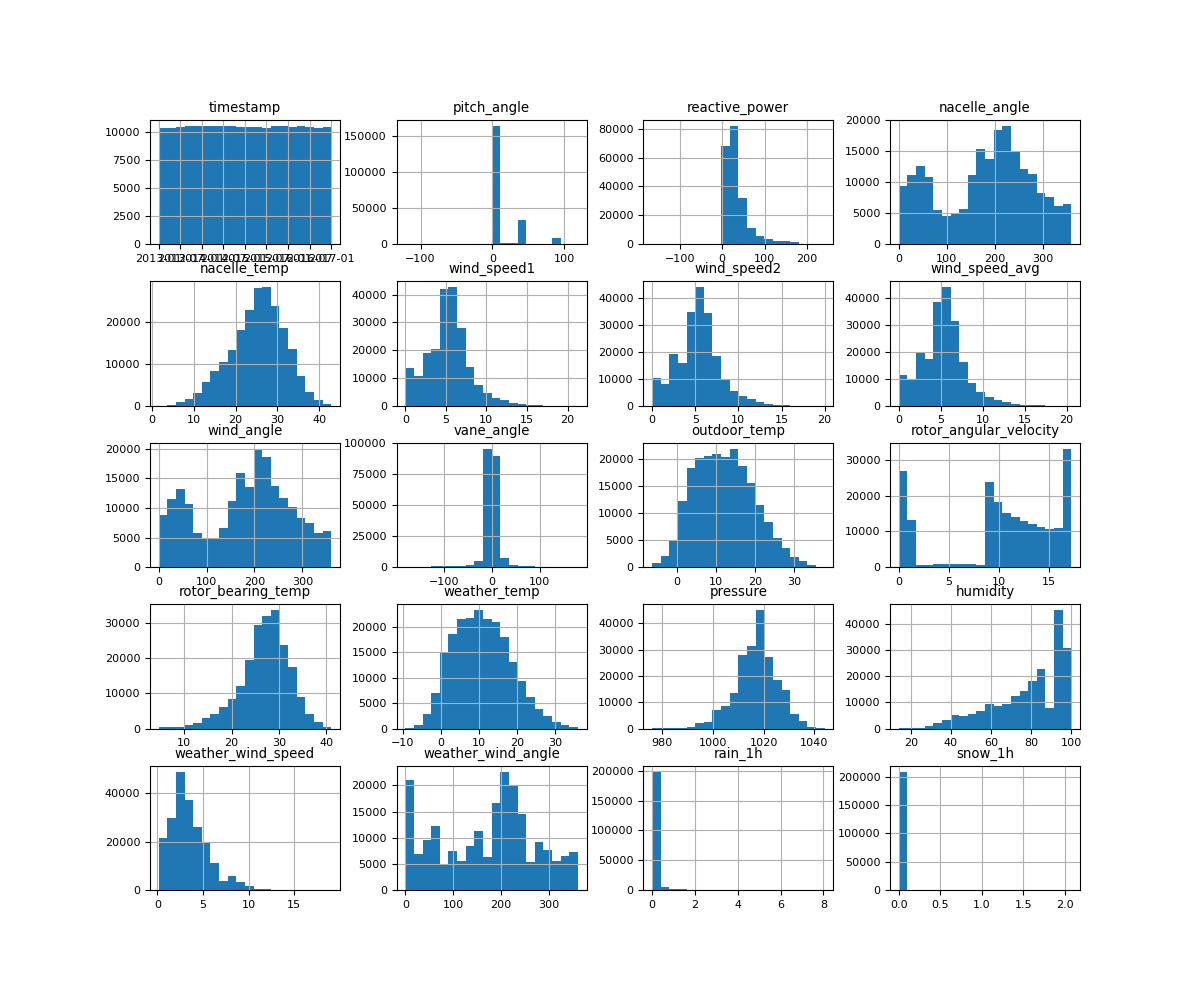

<IPython.core.display.Javascript object>


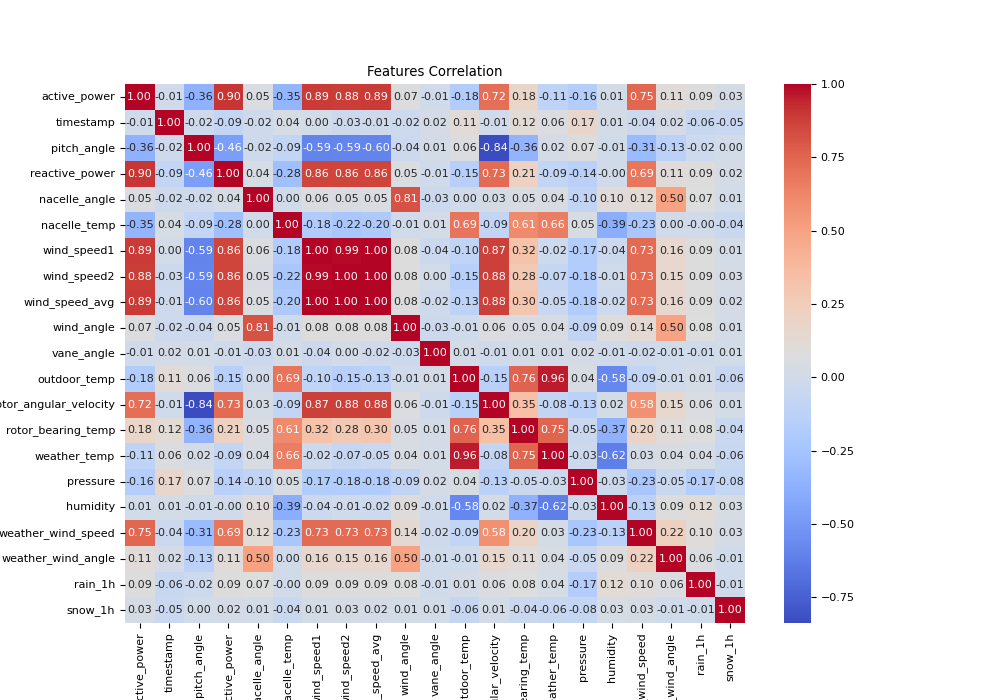

<IPython.core.display.Javascript object>


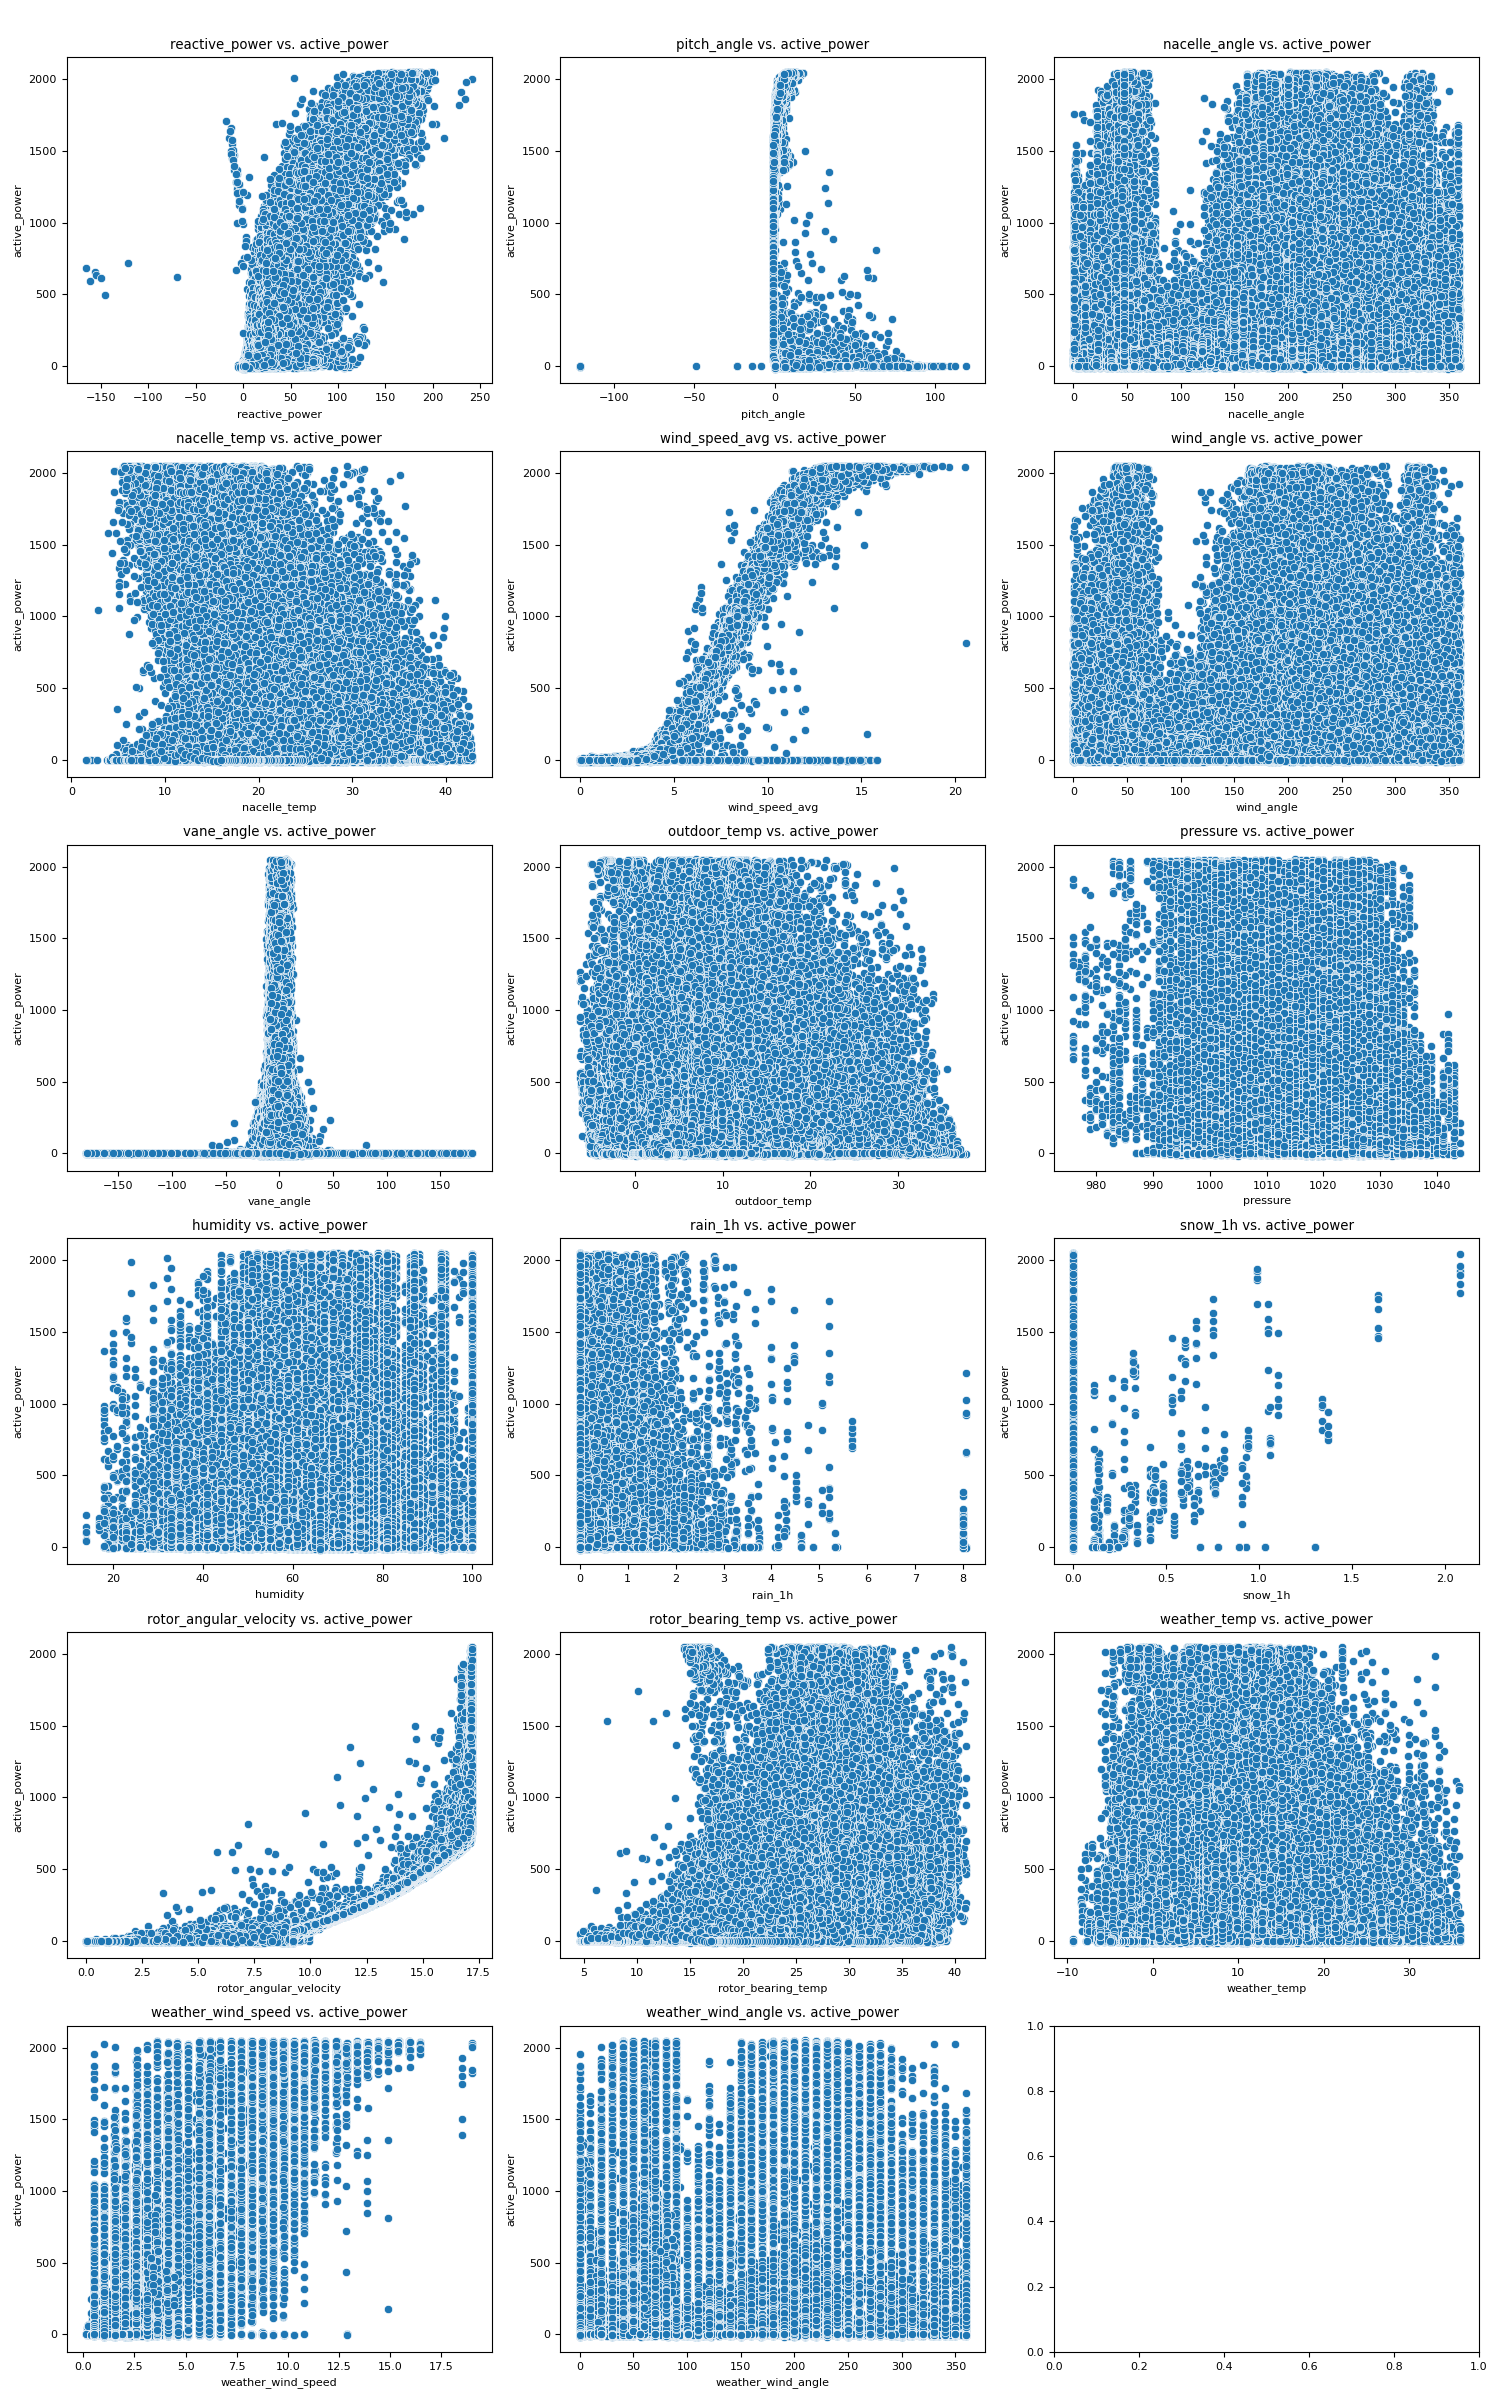

<IPython.core.display.Javascript object>


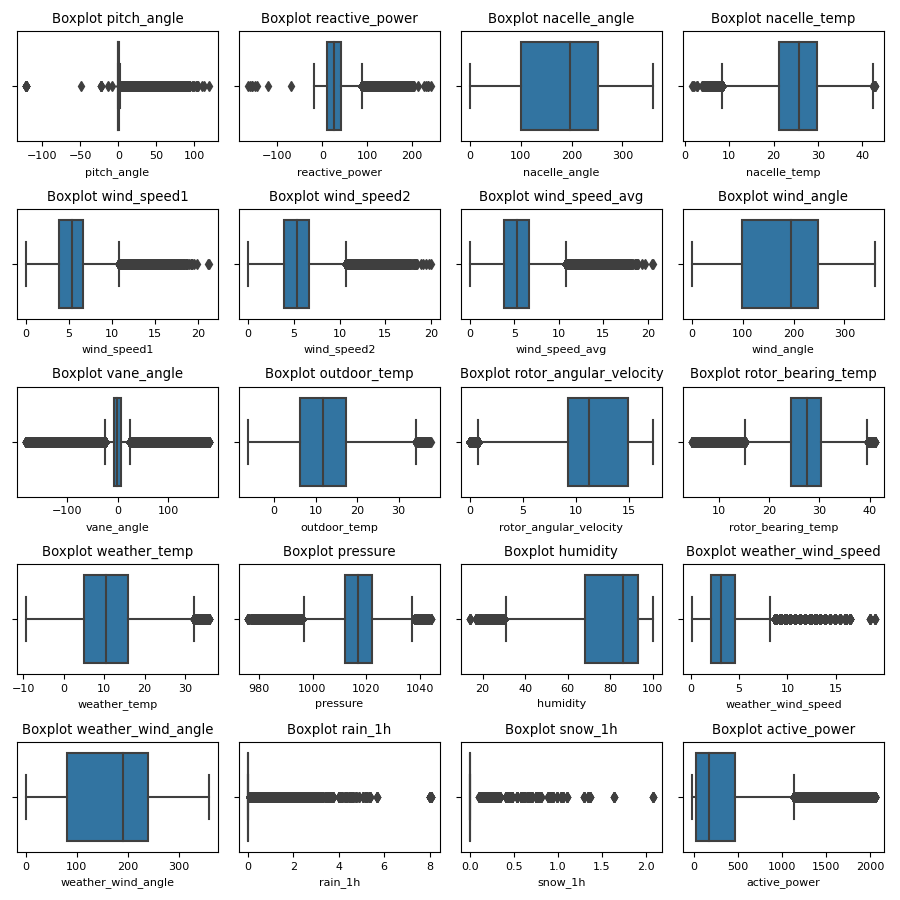

<IPython.core.display.Javascript object>


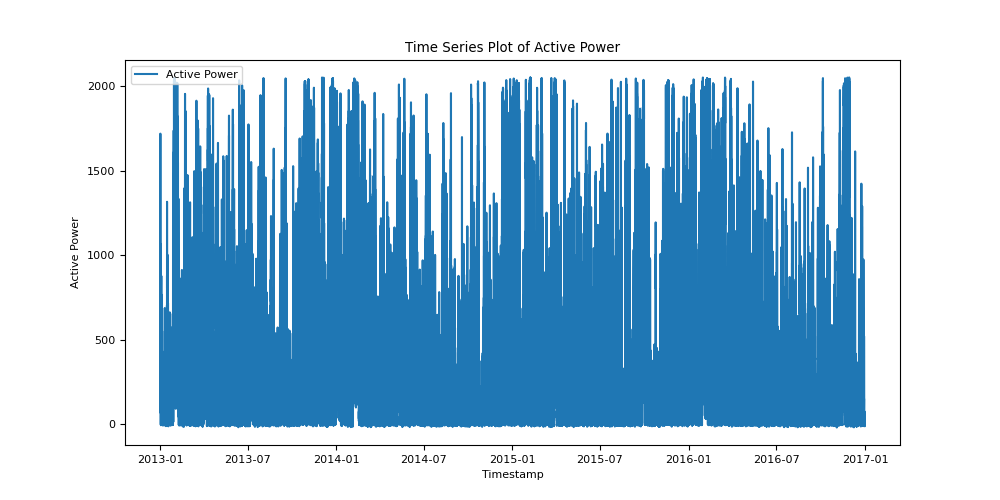

<IPython.core.display.Javascript object>


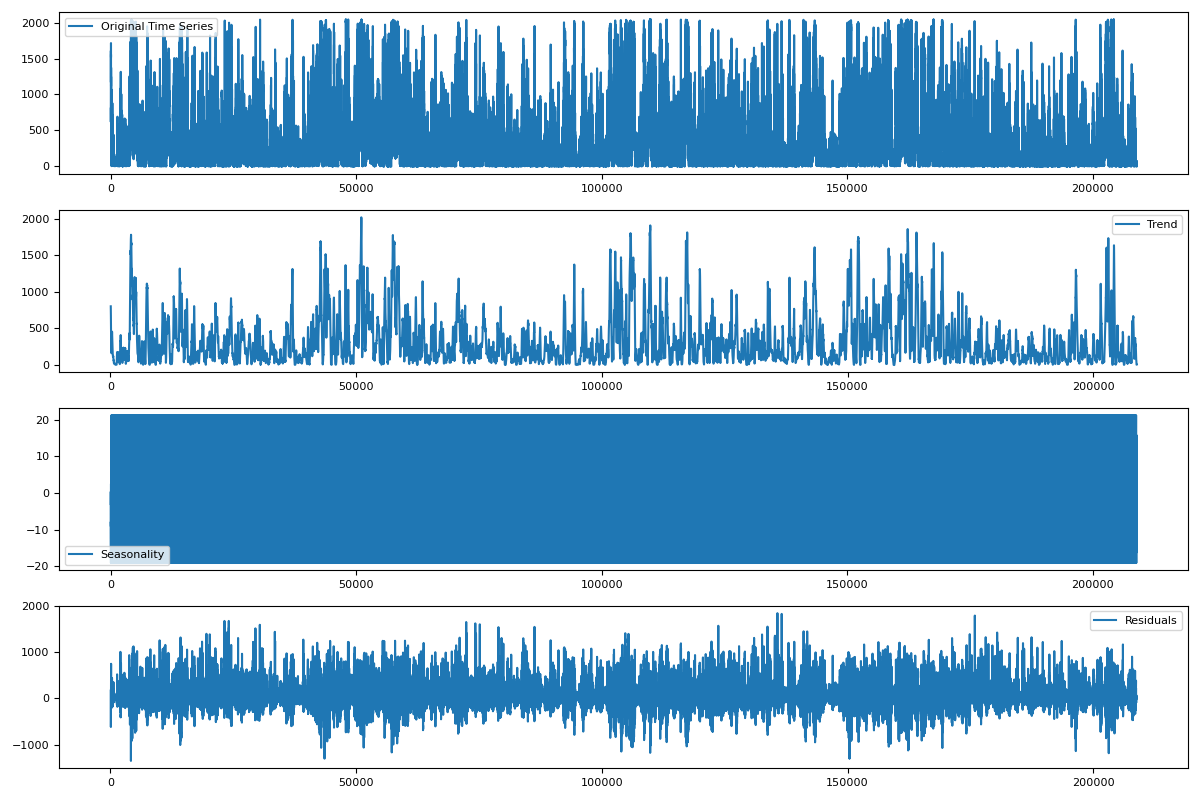

<IPython.core.display.Javascript object>


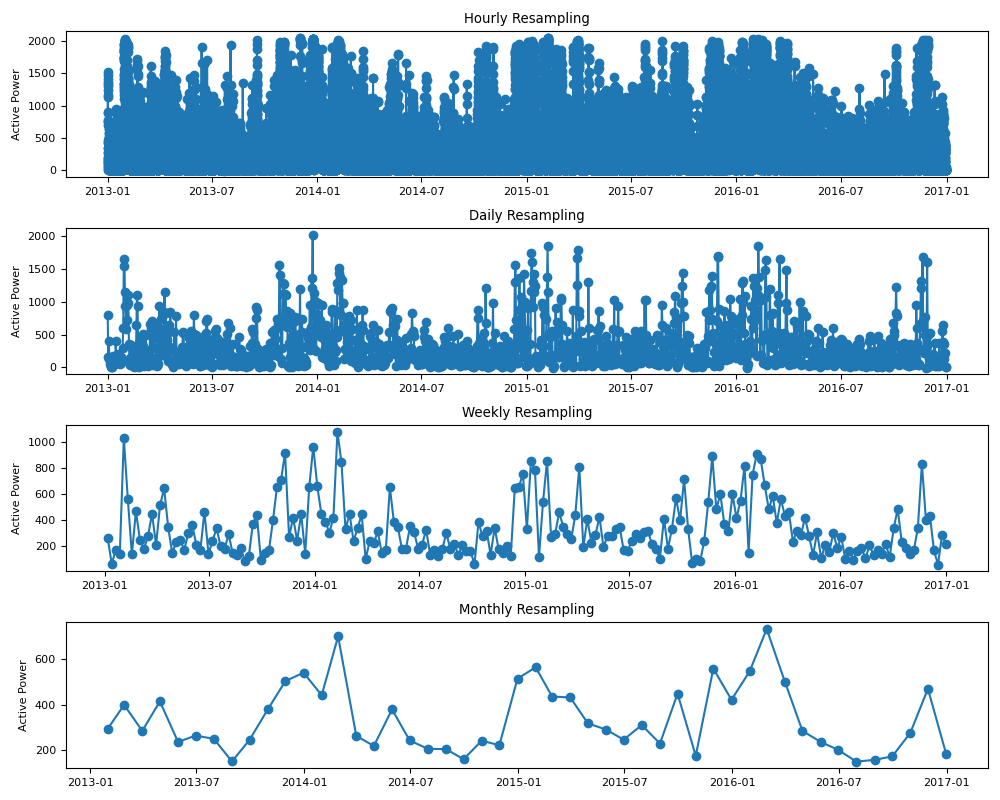

<IPython.core.display.Javascript object>


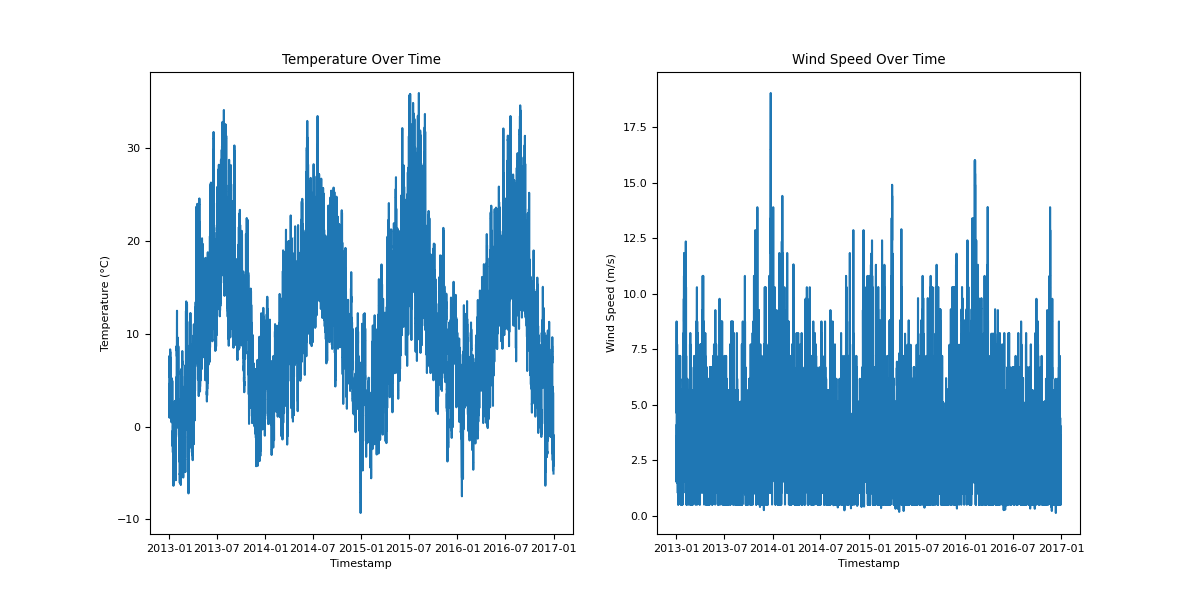

<IPython.core.display.Javascript object>


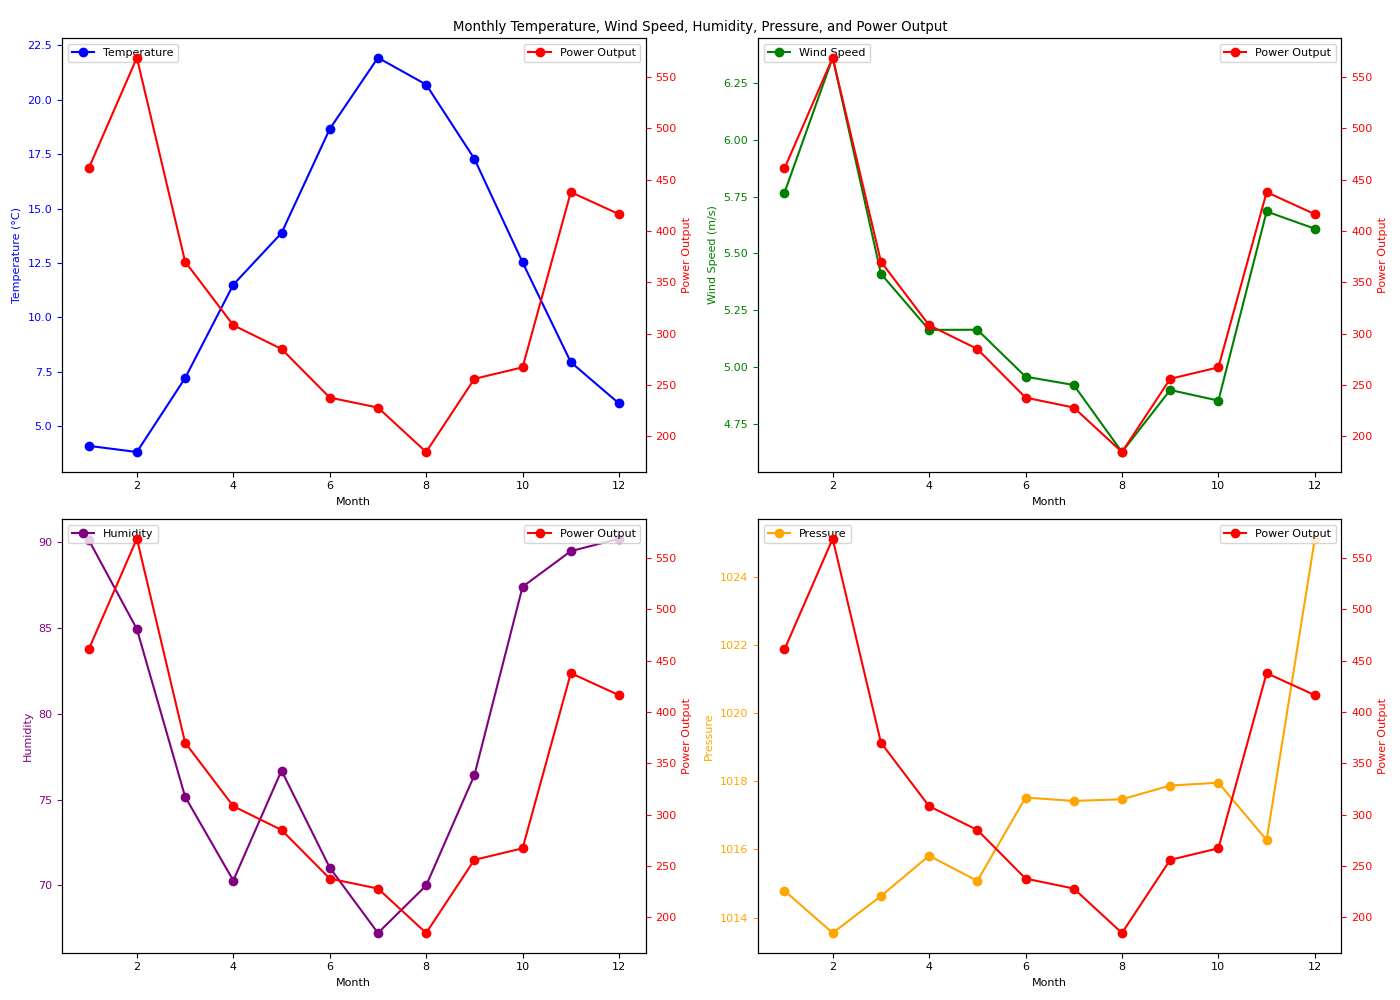

<IPython.core.display.Javascript object>


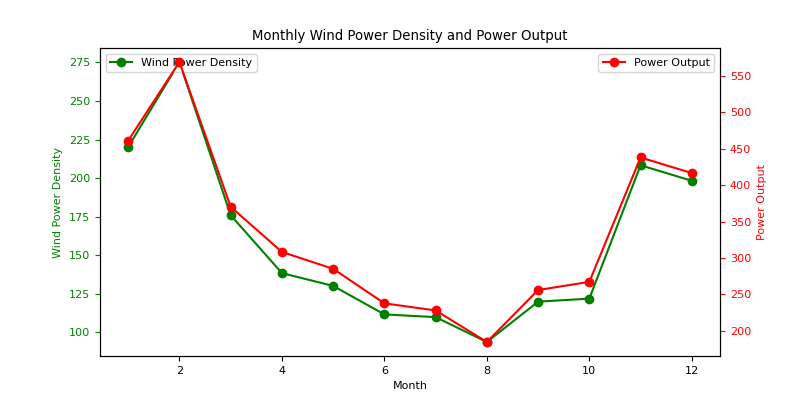

<IPython.core.display.Javascript object>


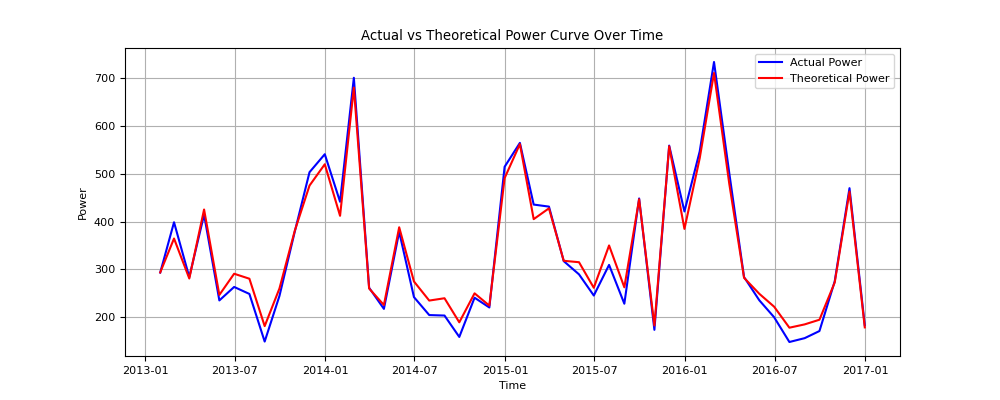

<IPython.core.display.Javascript object>


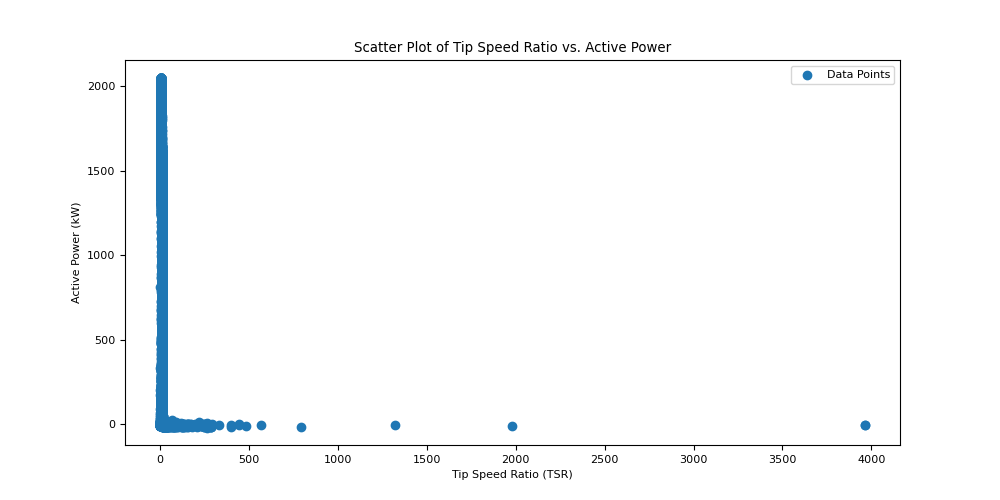

In [1]:
import import_ipynb
from EDA_Preprocessing import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Conv2D, MaxPooling2D, Flatten, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

## Model

##### Normalization/Standardization
For neural networks (NN), normalization or standardization is often essential, because NNs are sensitive to the scale of features.

##### Dimensionality reduction
Dimensionality reduction can be beneficial for NN when we are working with high-dimensional data. Reducing the number of features can improve NNs in terms of training speed and generalization. We can use techniques such as Principal Component Analysis (PCA).

##### Model
This model is a non-linear model. NN are composed of interconnected layers of neurons and they can learn complex relationships within the data.

The biggest problem with NN is that they can be prone to overfitting when having a deep and large architecture. This will lead to poor generalization to new, unseen data.
To avoid overfitting we can use regularization techniques, dropout layers and early stopping.
Other steps we can follow to improve the model are:
- creating new features to capture new relationships

## Preprocessing

To help the neural network capture the cyclic relationships in minute, hour, day, month and season, we will encode these features as sin and cos. The reason is that neural networks inherently don't have an understanding of cyclic features whereas decision trees for example can inherently capture these relationships. We use the following transformations:
$$
  x_{sin} = sin(\frac{2 * \pi * x}{max(x)})
$$ 

$$
  x_{cos} = cos(\frac{2 * \pi * x}{max(x)})
$$ 

In [2]:
def sine_transformation(data, value):
    return np.sin(2*np.pi*data/value)
    
def cosine_transformation(data, value):
    return np.cos(2*np.pi*data/value)
    
def minute_transformation(minutes):
    return (sine_transformation(minutes, 60), cosine_transformation(minutes, 60))

def hour_transformation(hours):
    return (sine_transformation(hours, 24), cosine_transformation(hours, 24))

def day_transformation(days):
    return (sine_transformation(days, 31), cosine_transformation(days, 31))

def month_transformation(months):
    return (sine_transformation(months, 12), cosine_transformation(months, 12))

def season_transformation(seasons):
    return (sine_transformation(seasons, 4), cosine_transformation(seasons, 4))

In [3]:
train_data['minute_sin'], train_data['minute_cos'] = minute_transformation(train_data['minute'])
train_data['hour_sin'], train_data['hour_cos'] = hour_transformation(train_data['hour'])
train_data['day_sin'], train_data['day_cos'] = day_transformation(train_data['day'])
train_data['month_sin'], train_data['month_cos'] = month_transformation(train_data['month'])
train_data['season_sin'], train_data['season_cos'] = season_transformation(train_data['season'])

train_data = train_data.drop(['hour', 'minute', 'day', 'month', 'season'], axis=1)

test_data['minute_sin'], test_data['minute_cos'] = minute_transformation(test_data['minute'])
test_data['hour_sin'], test_data['hour_cos'] = hour_transformation(test_data['hour'])
test_data['day_sin'], test_data['day_cos'] = day_transformation(test_data['day'])
test_data['month_sin'], test_data['month_cos'] = month_transformation(test_data['month'])
test_data['season_sin'], test_data['season_cos'] = season_transformation(test_data['season'])

test_data = test_data.drop(['hour', 'minute', 'day', 'month', 'season'], axis=1)

Let's see which features we need to transform te be able to correctly work with the neural networks.

<IPython.core.display.Javascript object>


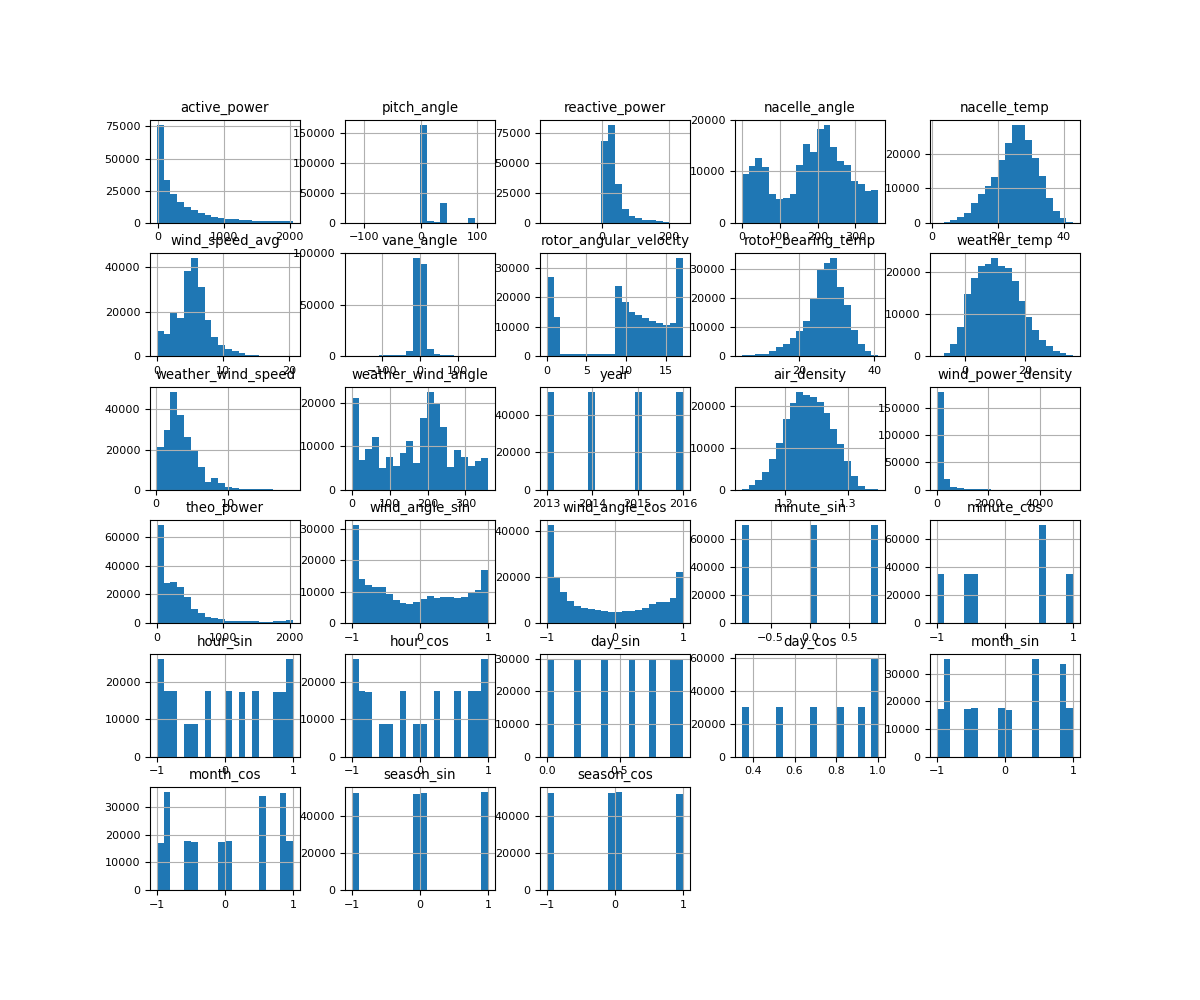

In [4]:
train_data.hist(figsize=(12, 10), bins=20) # plot a frequency histogram of each feature except target
plt.show()

As we can see from this plot, the data for active_power, reactive_power, wind_speed_avg, weather_wind_speed, theo_power and wind_power_density is positively skewed. Skewness might affect the interpretability of neural networks. To address this issue we will use the log1p transformation. This transformation is useful for handling right-skewed distributions.

In [5]:
#train_copy = train_data.copy()
#data_to_transform = ['theo_power', 'reactive_power', 'wind_speed_avg', 'weather_wind_speed', 'wind_power_density']
#selected_data = train_data[data_to_transform]
#transformed_data = selected_data.apply(lambda x: np.log1p(x-x.min()))
#train_data[data_to_transform] = transformed_data

I tried this transformation but it did not optimize the model. I created a back transformation function to be sure to transform the predictions when comparing.  I do not have a clear explanation on why but it might be because the log transformation lead to a loss of information.

<IPython.core.display.Javascript object>


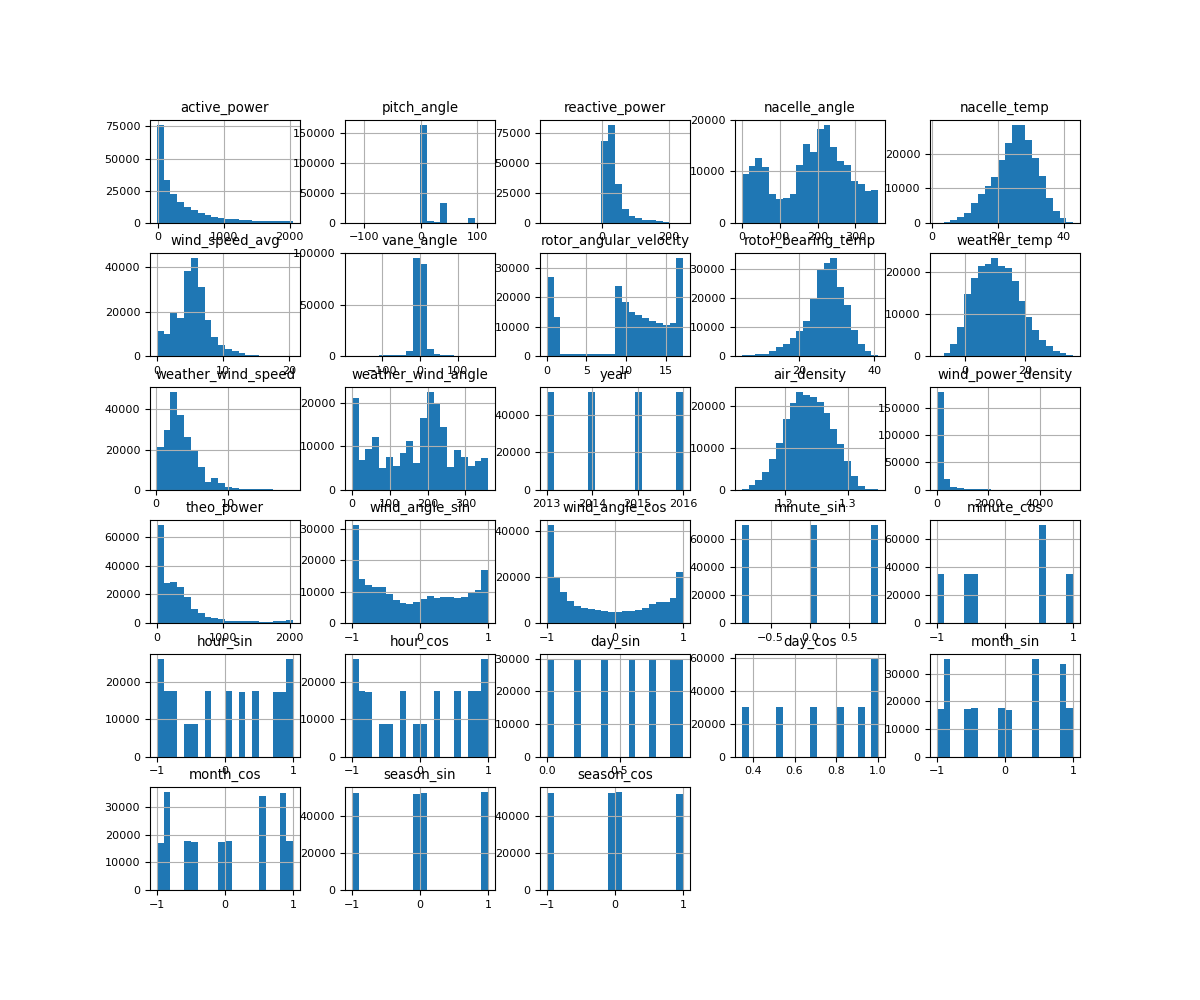

In [6]:
train_data.hist(figsize=(12, 10), bins=20) # plot a frequency histogram of each feature except target
plt.show()

## Training/validation/test split

In [7]:
tscv = TimeSeriesSplit(n_splits=10)

In [8]:
# extract the features and target variable from training set
X = train_data.drop([target], axis=1)
y = train_data[target]

# size for training is 80%
train_size = int(len(X)*0.8)

# split the dataset into training and validation set
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

## Model Training

### Feedforward Neural Network (FNN)

To start my journey with neural networks, I will start by creating a simple NN model. This model consists of 2 dense layers with ReLU activation function, followed by an output layer for regression. The first dense layer is used to capture non-linear relationships in the input features. The second layer adds complexity to enable the model to learn more complex patterns. The last layer is used to produce the predicted wind turbine power output.

We use the KerasRegressor as a wrapper to build the pipeline. We can not construct the pipeline directly with the neural network. We first need to wrap it using the KerasRegressor to be able to use tools such as hyperparameter tuning.

In [9]:
def create_nn_model():
    model = Sequential([
        # input layer with 64 neurons, ReLU activation function 
        # and the input dimension should match the number of features
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        # hidden layer with 32 neurons
        Dense(32, activation='relu'),
        # output layer with 1 neuron for regression
        Dense(1) 
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

# use RobustScaler because we have features that have outliers
# to avoid the influence of the outliers on scaling we use this scaler
pipeline = make_pipeline(RobustScaler(), KerasRegressor(build_fn=create_nn_model, epochs=50, batch_size=32, verbose=1))

# start tracing memory usage and train time
tracemalloc.start()
start_time = time.time()

# create pipeline with the model
pipeline.fit(X_train, y_train)

simple_nn_mem = tracemalloc.get_traced_memory()

tracemalloc.stop()
simple_nn_train_time = time.time() - start_time

# train the model
y_pred = pipeline.predict(X_val)

# predict on validation set
mae = mean_absolute_error(y_val, y_pred)
cv_scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
print(f'MAE: {mae}')
print(f'CV-MAE: {-cv_scores.mean()}')

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)



Epoch 1/50

5223/5223 [==============================] - 7s 1ms/step - loss: 37.6721
Epoch 2/50
5223/5223 [==============================] - 6s 1ms/step - loss: 14.9554
Epoch 3/50
5223/5223 [==============================] - 6s 1ms/step - loss: 13.1631
Epoch 4/50
5223/5223 [==============================] - 6s 1ms/step - loss: 12.3421
Epoch 5/50
5223/5223 [==============================] - 6s 1ms/step - loss: 11.8749
Epoch 6/50
5223/5223 [==============================] - 6s 1ms/step - loss: 11.5816
Epoch 7/50
5223/5223 [==============================] - 6s 1ms/step - loss: 11.3756
Epoch 8/50
5223/5223 [==============================] - 6s 1ms/step - loss: 11.1744
Epoch 9/50
5223/5223 [==============================] - 6s 1ms/step - loss: 11.0020
Epoch 10/50
5223/5223 [==============================] - 6s 1ms/step - loss: 10.8399
Epoch 11/50
5223/5223 [==============================] - 6s 1ms/step - loss: 10.6765
Epoch 12/50
5223/5223 [==============================] - 6s 1ms/step - l

Without drawing the learning curve we can see that the model might overfit. The MAE on the training set is considerabely lower than the CV-MAE. This means that the model fits closely to the training data and when generalizing, it fails.

To solve this issue we can use some techniques to adress overfitting such as regularization (by adding Dropout layers). Let's try improving the neural network by adding this technique.

In [10]:
def create_nn_model():
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        # dropout layer to prevent overfitting by randomly setting
        # 20% of the neurons to 0
        Dropout(0.2),  
        Dense(32, activation='relu'),
        Dropout(0.2),  
        Dense(1)  
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

# create pipeline with the model
pipeline = make_pipeline(RobustScaler(), KerasRegressor(build_fn=create_nn_model, epochs=50, batch_size=32, verbose=1))

tracemalloc.start()
start_time = time.time()

# train the model
pipeline.fit(X_train, y_train)

dropout_nn_mem = tracemalloc.get_traced_memory()

tracemalloc.stop()
dropout_nn_train_time = time.time() - start_time

# predict on validation set
y_pred = pipeline.predict(X_val)

# show the scores
mae = mean_absolute_error(y_val, y_pred)
cv_scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
print(f'MAE: {mae}')
print(f'CV-MAE: {-cv_scores.mean()}')

Epoch 1/50


C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5223/5223 [==============================] - 8s 1ms/step - loss: 64.9630
Epoch 2/50
5223/5223 [==============================] - 7s 1ms/step - loss: 47.9717
Epoch 3/50
5223/5223 [==============================] - 7s 1ms/step - loss: 46.8644
Epoch 4/50
5223/5223 [==============================] - 6s 1ms/step - loss: 46.4212
Epoch 5/50
5223/5223 [==============================] - 7s 1ms/step - loss: 45.9562
Epoch 6/50
5223/5223 [==============================] - 7s 1ms/step - loss: 45.7065
Epoch 7/50
5223/5223 [==============================] - 7s 1ms/step - loss: 45.2081
Epoch 8/50
5223/5223 [==============================] - 7s 1ms/step - loss: 44.7858
Epoch 9/50
5223/5223 [==============================] - 7s 1ms/step - loss: 44.7356
Epoch 10/50
5223/5223 [==============================] - 8s 2ms/step - loss: 44.6873
Epoch 11/50
5223/5223 [==============================] - 9s 2ms/step - loss: 44.1610
Epoch 12/50
5223/5223 [==============================] - 8s 2ms/step - loss: 44.1270


In [11]:
X_test = test_data

# Predict on the test set
prediction = pipeline.predict(X_test)

1633/1633 [==============================] - 1s 453us/step


### Recurrent Neural Network (RNN)

For the RNN we won't be working with a pipeline because drawing the learning curve when working with a pipeline is not working. I did not find any tutorial on the internet or in the wpo so I used the neural networks without a pipeline to be able to visualize the performance of the neural networks.

In [12]:
# extract the features and target variable from training set
X = train_data.drop([target], axis=1)
y = train_data[target]

# size for training is 80%
train_size = int(len(X)*0.8)

# split the dataset into training and validation set
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

First rescale the features to bring them to a similar scale. Then reshape the data to a 3-dimensional format because LSTM networks expects this format. Use RobustScaler to handle outliers.

In [13]:
# use RobustScaler to scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# reshape the data to a 3-dimensional format for LSTM model
n_features = X_train_scaled.shape[1]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, n_features)) # the 1 specifies the timesteps
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, n_features))

Begin by implementing a simple Long Short-Term Memory (LSTM) neural network.

In [14]:
def create_lstm_model():
    model = Sequential([
        # LSTM layer with 50 units
        LSTM(50, activation='relu', input_shape=(1, n_features)),
        Dense(1) 
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

model = create_lstm_model()

# save the losses to plot the learning curve
train_losses = []
val_losses = []

# trace memory usage and training time
tracemalloc.start()
start_time = time.time()

# train the model
epochs = 50
for epoch in range(epochs):  
    history = model.fit(X_train_reshaped, y_train, epochs=1, batch_size=32, validation_data=(X_val_reshaped, y_val), verbose=1)
    
    # keep track of the losses
    train_losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])
    
lstm_mem = tracemalloc.get_traced_memory()

tracemalloc.stop()
lstm_train_time = time.time() - start_time

y_val_pred = model.predict(X_val_reshaped)

mae = mean_absolute_error(y_val, y_val_pred)
print(f'Validation MAE: {mae}')

1306/1306 [==============================] - 1s 563us/step
Validation MAE: 7.614392611812998


<IPython.core.display.Javascript object>


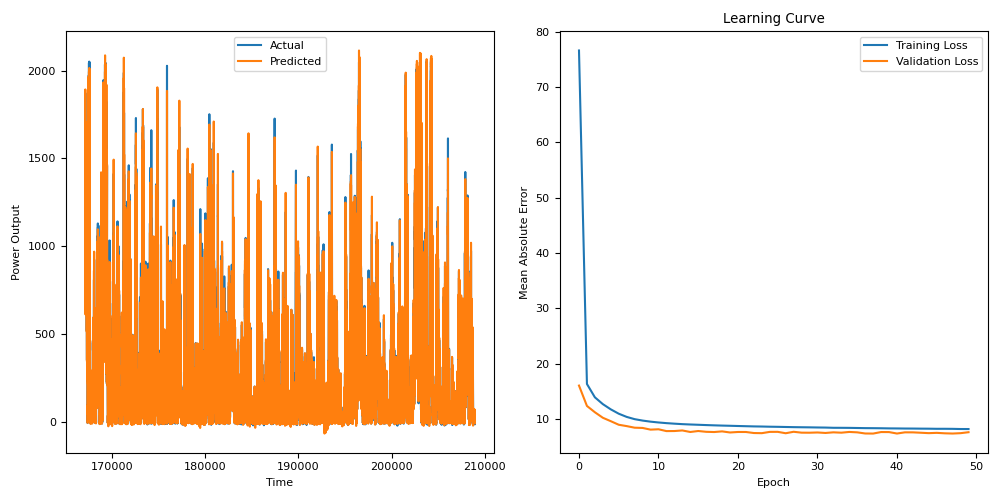

In [15]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(y_val, label='Actual')
plt.plot(y_val.index, y_val_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Power Output')
plt.legend()

# Plot learning curve
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve')
plt.legend()

plt.tight_layout()
plt.show()

On the first plot we can see the predicted and actual values. We can see that the model did some mistakes.

The learning curve shows a good fit. The training and validation loss are decreasing to a point of stability and the gap between them becomes smaller and smaller. This indicates that the model can make accurate predictions on unseen data.

The next step is to improve the model by using hyperparameter tuning.

In [16]:
def create_lstm_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(1, n_features)))
    model.add(Dense(1)) 
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    return model

# define the keras regressor
keras_regressor = KerasRegressor(build_fn=create_lstm_model, epochs=50, batch_size=32, verbose=1)

# choose parameters to search
parameters = {
    'optimizer': ['adam', 'rmsprop'],
    'loss': ['mean_absolute_error'],
    'epochs': [50, 100],
    'batch_size': [32, 64],
}

# use grid search to find best hyperparameters
gs = GridSearchCV(keras_regressor, parameters, cv=tscv, scoring='neg_mean_absolute_error')
gs_result = gs.fit(X_train_reshaped, y_train)

# print the best parameters
best_params = gs_result.best_params_
print(f'Best Hyperparameters: {best_params}')

# build the LSTM network using the best hyperparameters
best_model = create_lstm_model(best_params)

tracemalloc.start()
start_time = time.time()

# train the new model
best_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val), verbose=1)

tuned_lstm_mem = tracemalloc.get_traced_memory()

tracemalloc.stop()
tuned_lstm_train_time = time.time() - start_time

# predict on validation set
y_val_pred = best_model.predict(X_val_reshaped)

mae = mean_absolute_error(y_val, y_val_pred)
print(f'Validation MAE: {mae}')

Epoch 1/50


C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


475/475 [==============================] - 1s 737us/step - loss: 320.9427
Epoch 2/50
475/475 [==============================] - 0s 709us/step - loss: 190.2341
Epoch 3/50
475/475 [==============================] - 0s 719us/step - loss: 60.0402
Epoch 4/50
475/475 [==============================] - 0s 724us/step - loss: 27.6004
Epoch 5/50
475/475 [==============================] - 0s 737us/step - loss: 21.7967
Epoch 6/50
475/475 [==============================] - 0s 725us/step - loss: 18.4237
Epoch 7/50
475/475 [==============================] - 0s 718us/step - loss: 16.2238
Epoch 8/50
475/475 [==============================] - 0s 714us/step - loss: 14.9842
Epoch 9/50
475/475 [==============================] - 0s 720us/step - loss: 14.1702
Epoch 10/50
475/475 [==============================] - 0s 719us/step - loss: 13.5199
Epoch 11/50
475/475 [==============================] - 0s 709us/step - loss: 13.0095
Epoch 12/50
475/475 [==============================] - 0s 743us/step - loss: 12.500

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


950/950 [==============================] - 1s 723us/step - loss: 236.1127
Epoch 2/50
950/950 [==============================] - 1s 724us/step - loss: 53.7619
Epoch 3/50
950/950 [==============================] - 1s 717us/step - loss: 22.8740
Epoch 4/50
950/950 [==============================] - 1s 711us/step - loss: 16.3908
Epoch 5/50
950/950 [==============================] - 1s 707us/step - loss: 14.0258
Epoch 6/50
950/950 [==============================] - 1s 707us/step - loss: 12.8559
Epoch 7/50
950/950 [==============================] - 1s 743us/step - loss: 12.1492
Epoch 8/50
950/950 [==============================] - 1s 734us/step - loss: 11.6135
Epoch 9/50
950/950 [==============================] - 1s 727us/step - loss: 11.1423
Epoch 10/50
950/950 [==============================] - 1s 715us/step - loss: 10.7434
Epoch 11/50
950/950 [==============================] - 1s 715us/step - loss: 10.4072
Epoch 12/50
950/950 [==============================] - 1s 715us/step - loss: 10.1245

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1425/1425 [==============================] - 2s 736us/step - loss: 174.1730
Epoch 2/50
1425/1425 [==============================] - 1s 726us/step - loss: 30.1116
Epoch 3/50
1425/1425 [==============================] - 1s 739us/step - loss: 16.9875
Epoch 4/50
1425/1425 [==============================] - 1s 742us/step - loss: 13.5915
Epoch 5/50
1425/1425 [==============================] - 1s 727us/step - loss: 12.4041
Epoch 6/50
1425/1425 [==============================] - 1s 729us/step - loss: 11.6366
Epoch 7/50
1425/1425 [==============================] - 1s 746us/step - loss: 11.0649
Epoch 8/50
1425/1425 [==============================] - 1s 778us/step - loss: 10.6186
Epoch 9/50
1425/1425 [==============================] - 1s 734us/step - loss: 10.1881
Epoch 10/50
1425/1425 [==============================] - 1s 732us/step - loss: 9.8373
Epoch 11/50
1425/1425 [==============================] - 1s 732us/step - loss: 9.5550
Epoch 12/50
1425/1425 [==============================] - 1s 727u

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1900/1900 [==============================] - 2s 756us/step - loss: 168.8515
Epoch 2/50
1900/1900 [==============================] - 1s 777us/step - loss: 27.5930
Epoch 3/50
1900/1900 [==============================] - 1s 772us/step - loss: 16.9716
Epoch 4/50
1900/1900 [==============================] - 1s 741us/step - loss: 14.5563
Epoch 5/50
1900/1900 [==============================] - 1s 756us/step - loss: 13.1124
Epoch 6/50
1900/1900 [==============================] - 1s 750us/step - loss: 12.2311
Epoch 7/50
1900/1900 [==============================] - 1s 744us/step - loss: 11.6387
Epoch 8/50
1900/1900 [==============================] - 1s 754us/step - loss: 11.2106
Epoch 9/50
1900/1900 [==============================] - 1s 771us/step - loss: 10.8112
Epoch 10/50
1900/1900 [==============================] - 1s 749us/step - loss: 10.5134
Epoch 11/50
1900/1900 [==============================] - 1s 731us/step - loss: 10.2001
Epoch 12/50
1900/1900 [==============================] - 1s 75

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2375/2375 [==============================] - 2s 715us/step - loss: 126.6436
Epoch 2/50
2375/2375 [==============================] - 2s 720us/step - loss: 20.4232
Epoch 3/50
2375/2375 [==============================] - 2s 725us/step - loss: 15.0238
Epoch 4/50
2375/2375 [==============================] - 2s 721us/step - loss: 13.2503
Epoch 5/50
2375/2375 [==============================] - 2s 722us/step - loss: 12.2220
Epoch 6/50
2375/2375 [==============================] - 2s 724us/step - loss: 11.5300
Epoch 7/50
2375/2375 [==============================] - 2s 753us/step - loss: 11.0025
Epoch 8/50
2375/2375 [==============================] - 2s 726us/step - loss: 10.5894
Epoch 9/50
2375/2375 [==============================] - 2s 735us/step - loss: 10.2490
Epoch 10/50
2375/2375 [==============================] - 2s 712us/step - loss: 9.9448
Epoch 11/50
2375/2375 [==============================] - 2s 738us/step - loss: 9.6662
Epoch 12/50
2375/2375 [==============================] - 2s 729u

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2849/2849 [==============================] - 3s 733us/step - loss: 114.0656
Epoch 2/50
2849/2849 [==============================] - 2s 728us/step - loss: 17.8755
Epoch 3/50
2849/2849 [==============================] - 2s 733us/step - loss: 13.3718
Epoch 4/50
2849/2849 [==============================] - 2s 724us/step - loss: 11.8966
Epoch 5/50
2849/2849 [==============================] - 2s 726us/step - loss: 11.0302
Epoch 6/50
2849/2849 [==============================] - 2s 728us/step - loss: 10.4377
Epoch 7/50
2849/2849 [==============================] - 2s 726us/step - loss: 9.9469
Epoch 8/50
2849/2849 [==============================] - 2s 725us/step - loss: 9.5411
Epoch 9/50
2849/2849 [==============================] - 2s 746us/step - loss: 9.1797
Epoch 10/50
2849/2849 [==============================] - 2s 740us/step - loss: 8.8480
Epoch 11/50
2849/2849 [==============================] - 2s 721us/step - loss: 8.5675
Epoch 12/50
2849/2849 [==============================] - 2s 707us/s

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3324/3324 [==============================] - 3s 749us/step - loss: 101.3125
Epoch 2/50
3324/3324 [==============================] - 2s 732us/step - loss: 17.0718
Epoch 3/50
3324/3324 [==============================] - 2s 738us/step - loss: 13.5216
Epoch 4/50
3324/3324 [==============================] - 2s 752us/step - loss: 12.1628
Epoch 5/50
3324/3324 [==============================] - 2s 735us/step - loss: 11.3011
Epoch 6/50
3324/3324 [==============================] - 2s 748us/step - loss: 10.6553
Epoch 7/50
3324/3324 [==============================] - 2s 725us/step - loss: 10.1347
Epoch 8/50
3324/3324 [==============================] - 2s 742us/step - loss: 9.6360
Epoch 9/50
3324/3324 [==============================] - 2s 735us/step - loss: 9.2302
Epoch 10/50
3324/3324 [==============================] - 3s 778us/step - loss: 8.9243
Epoch 11/50
3324/3324 [==============================] - 3s 758us/step - loss: 8.6725
Epoch 12/50
3324/3324 [==============================] - 2s 746us/

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3799/3799 [==============================] - 3s 750us/step - loss: 95.2740
Epoch 2/50
3799/3799 [==============================] - 3s 743us/step - loss: 17.7361
Epoch 3/50
3799/3799 [==============================] - 3s 723us/step - loss: 14.0659
Epoch 4/50
3799/3799 [==============================] - 3s 719us/step - loss: 12.5420
Epoch 5/50
3799/3799 [==============================] - 3s 725us/step - loss: 11.6171
Epoch 6/50
3799/3799 [==============================] - 3s 717us/step - loss: 10.9628
Epoch 7/50
3799/3799 [==============================] - 3s 718us/step - loss: 10.4219
Epoch 8/50
3799/3799 [==============================] - 3s 718us/step - loss: 9.9716
Epoch 9/50
3799/3799 [==============================] - 3s 734us/step - loss: 9.6059
Epoch 10/50
3799/3799 [==============================] - 3s 733us/step - loss: 9.3138
Epoch 11/50
3799/3799 [==============================] - 3s 732us/step - loss: 9.1150
Epoch 12/50
3799/3799 [==============================] - 3s 726us/s

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4274/4274 [==============================] - 4s 737us/step - loss: 85.3299
Epoch 2/50
4274/4274 [==============================] - 3s 739us/step - loss: 16.7012
Epoch 3/50
4274/4274 [==============================] - 3s 740us/step - loss: 13.6293
Epoch 4/50
4274/4274 [==============================] - 3s 744us/step - loss: 12.2328
Epoch 5/50
4274/4274 [==============================] - 3s 744us/step - loss: 11.3319
Epoch 6/50
4274/4274 [==============================] - 3s 744us/step - loss: 10.5936
Epoch 7/50
4274/4274 [==============================] - 3s 746us/step - loss: 10.0175
Epoch 8/50
4274/4274 [==============================] - 3s 757us/step - loss: 9.5799
Epoch 9/50
4274/4274 [==============================] - 3s 745us/step - loss: 9.2681
Epoch 10/50
4274/4274 [==============================] - 3s 794us/step - loss: 9.0272
Epoch 11/50
4274/4274 [==============================] - 3s 761us/step - loss: 8.8465
Epoch 12/50
4274/4274 [==============================] - 3s 744us/s

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4748/4748 [==============================] - 4s 745us/step - loss: 80.1583
Epoch 2/50
4748/4748 [==============================] - 3s 723us/step - loss: 15.6320
Epoch 3/50
4748/4748 [==============================] - 3s 725us/step - loss: 13.0708
Epoch 4/50
4748/4748 [==============================] - 4s 751us/step - loss: 11.8521
Epoch 5/50
4748/4748 [==============================] - 4s 769us/step - loss: 11.0174
Epoch 6/50
4748/4748 [==============================] - 4s 752us/step - loss: 10.3524
Epoch 7/50
4748/4748 [==============================] - 4s 744us/step - loss: 9.8345
Epoch 8/50
4748/4748 [==============================] - 3s 736us/step - loss: 9.4488
Epoch 9/50
4748/4748 [==============================] - 4s 757us/step - loss: 9.1535
Epoch 10/50
4748/4748 [==============================] - 4s 760us/step - loss: 8.9531
Epoch 11/50
4748/4748 [==============================] - 4s 747us/step - loss: 8.7950
Epoch 12/50
4748/4748 [==============================] - 4s 753us/st

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


475/475 [==============================] - 1s 744us/step - loss: 316.5557
Epoch 2/50
475/475 [==============================] - 0s 746us/step - loss: 163.7998
Epoch 3/50
475/475 [==============================] - 0s 756us/step - loss: 43.5770
Epoch 4/50
475/475 [==============================] - 0s 717us/step - loss: 25.8008
Epoch 5/50
475/475 [==============================] - 0s 798us/step - loss: 20.4368
Epoch 6/50
475/475 [==============================] - 0s 751us/step - loss: 17.2124
Epoch 7/50
475/475 [==============================] - 0s 747us/step - loss: 15.6614
Epoch 8/50
475/475 [==============================] - 0s 744us/step - loss: 14.7621
Epoch 9/50
475/475 [==============================] - 0s 740us/step - loss: 14.0493
Epoch 10/50
475/475 [==============================] - 0s 727us/step - loss: 13.4154
Epoch 11/50
475/475 [==============================] - 0s 728us/step - loss: 12.9549
Epoch 12/50
475/475 [==============================] - 0s 741us/step - loss: 12.489

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


950/950 [==============================] - 1s 729us/step - loss: 227.7905
Epoch 2/50
950/950 [==============================] - 1s 720us/step - loss: 48.5721
Epoch 3/50
950/950 [==============================] - 1s 713us/step - loss: 22.8185
Epoch 4/50
950/950 [==============================] - 1s 715us/step - loss: 16.5544
Epoch 5/50
950/950 [==============================] - 1s 715us/step - loss: 14.1575
Epoch 6/50
950/950 [==============================] - 1s 714us/step - loss: 12.8812
Epoch 7/50
950/950 [==============================] - 1s 716us/step - loss: 12.0642
Epoch 8/50
950/950 [==============================] - 1s 712us/step - loss: 11.4832
Epoch 9/50
950/950 [==============================] - 1s 715us/step - loss: 11.0227
Epoch 10/50
950/950 [==============================] - 1s 715us/step - loss: 10.6588
Epoch 11/50
950/950 [==============================] - 1s 711us/step - loss: 10.3033
Epoch 12/50
950/950 [==============================] - 1s 712us/step - loss: 10.0234

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1425/1425 [==============================] - 2s 724us/step - loss: 160.5201
Epoch 2/50
1425/1425 [==============================] - 1s 712us/step - loss: 29.0183
Epoch 3/50
1425/1425 [==============================] - 1s 712us/step - loss: 16.7504
Epoch 4/50
1425/1425 [==============================] - 1s 717us/step - loss: 13.7434
Epoch 5/50
1425/1425 [==============================] - 1s 717us/step - loss: 12.5311
Epoch 6/50
1425/1425 [==============================] - 1s 710us/step - loss: 11.7129
Epoch 7/50
1425/1425 [==============================] - 1s 726us/step - loss: 11.1007
Epoch 8/50
1425/1425 [==============================] - 1s 726us/step - loss: 10.5846
Epoch 9/50
1425/1425 [==============================] - 1s 714us/step - loss: 10.1753
Epoch 10/50
1425/1425 [==============================] - 1s 713us/step - loss: 9.8205
Epoch 11/50
1425/1425 [==============================] - 1s 718us/step - loss: 9.5162
Epoch 12/50
1425/1425 [==============================] - 1s 715u

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1900/1900 [==============================] - 2s 724us/step - loss: 160.6712
Epoch 2/50
1900/1900 [==============================] - 1s 728us/step - loss: 26.3640
Epoch 3/50
1900/1900 [==============================] - 1s 738us/step - loss: 16.9596
Epoch 4/50
1900/1900 [==============================] - 1s 725us/step - loss: 14.4922
Epoch 5/50
1900/1900 [==============================] - 1s 721us/step - loss: 13.1181
Epoch 6/50
1900/1900 [==============================] - 1s 726us/step - loss: 12.2094
Epoch 7/50
1900/1900 [==============================] - 1s 722us/step - loss: 11.6044
Epoch 8/50
1900/1900 [==============================] - 1s 723us/step - loss: 11.1708
Epoch 9/50
1900/1900 [==============================] - 1s 726us/step - loss: 10.8056
Epoch 10/50
1900/1900 [==============================] - 1s 723us/step - loss: 10.5285
Epoch 11/50
1900/1900 [==============================] - 1s 728us/step - loss: 10.2633
Epoch 12/50
1900/1900 [==============================] - 1s 72

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2375/2375 [==============================] - 2s 729us/step - loss: 141.3044
Epoch 2/50
2375/2375 [==============================] - 2s 729us/step - loss: 23.5585
Epoch 3/50
2375/2375 [==============================] - 2s 723us/step - loss: 15.8745
Epoch 4/50
2375/2375 [==============================] - 2s 721us/step - loss: 13.6635
Epoch 5/50
2375/2375 [==============================] - 2s 726us/step - loss: 12.4369
Epoch 6/50
2375/2375 [==============================] - 2s 727us/step - loss: 11.6416
Epoch 7/50
2375/2375 [==============================] - 2s 720us/step - loss: 11.0493
Epoch 8/50
2375/2375 [==============================] - 2s 734us/step - loss: 10.5764
Epoch 9/50
2375/2375 [==============================] - 2s 724us/step - loss: 10.1861
Epoch 10/50
2375/2375 [==============================] - 2s 723us/step - loss: 9.8610
Epoch 11/50
2375/2375 [==============================] - 2s 725us/step - loss: 9.5630
Epoch 12/50
2375/2375 [==============================] - 2s 727u

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2849/2849 [==============================] - 3s 724us/step - loss: 108.8628
Epoch 2/50
2849/2849 [==============================] - 2s 722us/step - loss: 17.8728
Epoch 3/50
2849/2849 [==============================] - 2s 737us/step - loss: 13.4735
Epoch 4/50
2849/2849 [==============================] - 2s 727us/step - loss: 12.0394
Epoch 5/50
2849/2849 [==============================] - 2s 728us/step - loss: 11.1575
Epoch 6/50
2849/2849 [==============================] - 2s 722us/step - loss: 10.5039
Epoch 7/50
2849/2849 [==============================] - 2s 724us/step - loss: 10.0146
Epoch 8/50
2849/2849 [==============================] - 2s 727us/step - loss: 9.5981
Epoch 9/50
2849/2849 [==============================] - 2s 729us/step - loss: 9.2312
Epoch 10/50
2849/2849 [==============================] - 2s 733us/step - loss: 8.8953
Epoch 11/50
2849/2849 [==============================] - 2s 719us/step - loss: 8.6049
Epoch 12/50
2849/2849 [==============================] - 2s 716us/

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3324/3324 [==============================] - 3s 728us/step - loss: 91.8477
Epoch 2/50
3324/3324 [==============================] - 2s 721us/step - loss: 16.6167
Epoch 3/50
3324/3324 [==============================] - 2s 733us/step - loss: 13.5939
Epoch 4/50
3324/3324 [==============================] - 2s 726us/step - loss: 12.4291
Epoch 5/50
3324/3324 [==============================] - 2s 744us/step - loss: 11.6393
Epoch 6/50
3324/3324 [==============================] - 2s 717us/step - loss: 11.0706
Epoch 7/50
3324/3324 [==============================] - 2s 715us/step - loss: 10.5664
Epoch 8/50
3324/3324 [==============================] - 2s 722us/step - loss: 10.1113
Epoch 9/50
3324/3324 [==============================] - 2s 728us/step - loss: 9.6911
Epoch 10/50
3324/3324 [==============================] - 2s 735us/step - loss: 9.3127
Epoch 11/50
3324/3324 [==============================] - 2s 734us/step - loss: 8.9947
Epoch 12/50
3324/3324 [==============================] - 2s 738us/

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3799/3799 [==============================] - 3s 744us/step - loss: 97.1923
Epoch 2/50
3799/3799 [==============================] - 3s 726us/step - loss: 17.3574
Epoch 3/50
3799/3799 [==============================] - 3s 724us/step - loss: 14.0477
Epoch 4/50
3799/3799 [==============================] - 3s 720us/step - loss: 12.5846
Epoch 5/50
3799/3799 [==============================] - 3s 719us/step - loss: 11.7091
Epoch 6/50
3799/3799 [==============================] - 3s 720us/step - loss: 11.0669
Epoch 7/50
3799/3799 [==============================] - 3s 730us/step - loss: 10.5126
Epoch 8/50
3799/3799 [==============================] - 3s 723us/step - loss: 10.0265
Epoch 9/50
3799/3799 [==============================] - 3s 726us/step - loss: 9.6185
Epoch 10/50
3799/3799 [==============================] - 3s 725us/step - loss: 9.2834
Epoch 11/50
3799/3799 [==============================] - 3s 719us/step - loss: 9.0607
Epoch 12/50
3799/3799 [==============================] - 3s 722us/

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4274/4274 [==============================] - 4s 734us/step - loss: 80.4609
Epoch 2/50
4274/4274 [==============================] - 3s 729us/step - loss: 16.2312
Epoch 3/50
4274/4274 [==============================] - 3s 732us/step - loss: 13.3398
Epoch 4/50
4274/4274 [==============================] - 3s 724us/step - loss: 11.9693
Epoch 5/50
4274/4274 [==============================] - 3s 725us/step - loss: 11.1267
Epoch 6/50
4274/4274 [==============================] - 3s 723us/step - loss: 10.4398
Epoch 7/50
4274/4274 [==============================] - 3s 720us/step - loss: 9.8423
Epoch 8/50
4274/4274 [==============================] - 3s 730us/step - loss: 9.3963
Epoch 9/50
4274/4274 [==============================] - 3s 730us/step - loss: 9.0635
Epoch 10/50
4274/4274 [==============================] - 3s 733us/step - loss: 8.8581
Epoch 11/50
4274/4274 [==============================] - 3s 734us/step - loss: 8.7257
Epoch 12/50
4274/4274 [==============================] - 3s 726us/st

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4748/4748 [==============================] - 4s 777us/step - loss: 76.6571
Epoch 2/50
4748/4748 [==============================] - 4s 747us/step - loss: 15.5889
Epoch 3/50
4748/4748 [==============================] - 4s 747us/step - loss: 13.0678
Epoch 4/50
4748/4748 [==============================] - 3s 731us/step - loss: 11.7584
Epoch 5/50
4748/4748 [==============================] - 3s 731us/step - loss: 10.7944
Epoch 6/50
4748/4748 [==============================] - 3s 737us/step - loss: 10.0439
Epoch 7/50
4748/4748 [==============================] - 3s 729us/step - loss: 9.4996
Epoch 8/50
4748/4748 [==============================] - 4s 760us/step - loss: 9.1532
Epoch 9/50
4748/4748 [==============================] - 4s 763us/step - loss: 8.9060
Epoch 10/50
4748/4748 [==============================] - 3s 727us/step - loss: 8.7444
Epoch 11/50
4748/4748 [==============================] - 3s 713us/step - loss: 8.6230
Epoch 12/50
4748/4748 [==============================] - 3s 721us/st

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


475/475 [==============================] - 1s 735us/step - loss: 311.0671
Epoch 2/100
475/475 [==============================] - 0s 740us/step - loss: 147.3661
Epoch 3/100
475/475 [==============================] - 0s 743us/step - loss: 38.0640
Epoch 4/100
475/475 [==============================] - 0s 726us/step - loss: 24.7129
Epoch 5/100
475/475 [==============================] - 0s 726us/step - loss: 19.5649
Epoch 6/100
475/475 [==============================] - 0s 756us/step - loss: 16.4800
Epoch 7/100
475/475 [==============================] - 0s 729us/step - loss: 15.2706
Epoch 8/100
475/475 [==============================] - 0s 735us/step - loss: 14.4885
Epoch 9/100
475/475 [==============================] - 0s 730us/step - loss: 13.8543
Epoch 10/100
475/475 [==============================] - 0s 738us/step - loss: 13.2837
Epoch 11/100
475/475 [==============================] - 0s 719us/step - loss: 12.7972
Epoch 12/100
475/475 [==============================] - 0s 721us/step - l

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


950/950 [==============================] - 1s 741us/step - loss: 223.8589
Epoch 2/100
950/950 [==============================] - 1s 728us/step - loss: 46.4853
Epoch 3/100
950/950 [==============================] - 1s 726us/step - loss: 22.5912
Epoch 4/100
950/950 [==============================] - 1s 733us/step - loss: 16.8294
Epoch 5/100
950/950 [==============================] - 1s 732us/step - loss: 14.4400
Epoch 6/100
950/950 [==============================] - 1s 723us/step - loss: 13.0606
Epoch 7/100
950/950 [==============================] - 1s 714us/step - loss: 12.2299
Epoch 8/100
950/950 [==============================] - 1s 720us/step - loss: 11.6332
Epoch 9/100
950/950 [==============================] - 1s 732us/step - loss: 11.1638
Epoch 10/100
950/950 [==============================] - 1s 759us/step - loss: 10.8032
Epoch 11/100
950/950 [==============================] - 1s 727us/step - loss: 10.4981
Epoch 12/100
950/950 [==============================] - 1s 724us/step - lo

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1425/1425 [==============================] - 2s 753us/step - loss: 176.8405
Epoch 2/100
1425/1425 [==============================] - 1s 737us/step - loss: 29.7099
Epoch 3/100
1425/1425 [==============================] - 1s 735us/step - loss: 17.2417
Epoch 4/100
1425/1425 [==============================] - 1s 729us/step - loss: 13.7213
Epoch 5/100
1425/1425 [==============================] - 1s 732us/step - loss: 12.5028
Epoch 6/100
1425/1425 [==============================] - 1s 723us/step - loss: 11.7390
Epoch 7/100
1425/1425 [==============================] - 1s 723us/step - loss: 11.1800
Epoch 8/100
1425/1425 [==============================] - 1s 728us/step - loss: 10.7082
Epoch 9/100
1425/1425 [==============================] - 1s 725us/step - loss: 10.2979
Epoch 10/100
1425/1425 [==============================] - 1s 726us/step - loss: 9.8986
Epoch 11/100
1425/1425 [==============================] - 1s 727us/step - loss: 9.5704
Epoch 12/100
1425/1425 [==============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1900/1900 [==============================] - 2s 726us/step - loss: 151.6738
Epoch 2/100
1900/1900 [==============================] - 1s 726us/step - loss: 25.4103
Epoch 3/100
1900/1900 [==============================] - 1s 728us/step - loss: 16.6393
Epoch 4/100
1900/1900 [==============================] - 1s 729us/step - loss: 14.3188
Epoch 5/100
1900/1900 [==============================] - 1s 729us/step - loss: 13.0241
Epoch 6/100
1900/1900 [==============================] - 1s 747us/step - loss: 12.1993
Epoch 7/100
1900/1900 [==============================] - 1s 731us/step - loss: 11.6030
Epoch 8/100
1900/1900 [==============================] - 1s 722us/step - loss: 11.1977
Epoch 9/100
1900/1900 [==============================] - 1s 726us/step - loss: 10.8711
Epoch 10/100
1900/1900 [==============================] - 1s 726us/step - loss: 10.5898
Epoch 11/100
1900/1900 [==============================] - 1s 733us/step - loss: 10.3600
Epoch 12/100
1900/1900 [============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2375/2375 [==============================] - 2s 728us/step - loss: 137.8877
Epoch 2/100
2375/2375 [==============================] - 2s 723us/step - loss: 23.1862
Epoch 3/100
2375/2375 [==============================] - 2s 724us/step - loss: 15.6088
Epoch 4/100
2375/2375 [==============================] - 2s 722us/step - loss: 13.6423
Epoch 5/100
2375/2375 [==============================] - 2s 728us/step - loss: 12.4212
Epoch 6/100
2375/2375 [==============================] - 2s 729us/step - loss: 11.5385
Epoch 7/100
2375/2375 [==============================] - 2s 731us/step - loss: 10.9045
Epoch 8/100
2375/2375 [==============================] - 2s 729us/step - loss: 10.4157
Epoch 9/100
2375/2375 [==============================] - 2s 724us/step - loss: 9.9685
Epoch 10/100
2375/2375 [==============================] - 2s 726us/step - loss: 9.5964
Epoch 11/100
2375/2375 [==============================] - 2s 726us/step - loss: 9.2918
Epoch 12/100
2375/2375 [==============================]

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
2849/2849 [==============================] - 3s 737us/step - loss: 112.4375
Epoch 2/100
2849/2849 [==============================] - 2s 729us/step - loss: 18.1855
Epoch 3/100
2849/2849 [==============================] - 2s 724us/step - loss: 13.6224
Epoch 4/100
2849/2849 [==============================] - 2s 724us/step - loss: 12.0606
Epoch 5/100
2849/2849 [==============================] - 2s 721us/step - loss: 11.1246
Epoch 6/100
2849/2849 [==============================] - 2s 731us/step - loss: 10.4821
Epoch 7/100
2849/2849 [==============================] - 2s 746us/step - loss: 9.9584
Epoch 8/100
2849/2849 [==============================] - 2s 734us/step - loss: 9.5401
Epoch 9/100
2849/2849 [==============================] - 2s 727us/step - loss: 9.1646
Epoch 10/100
2849/2849 [==============================] - 2s 728us/step - loss: 8.8395
Epoch 11/100
2849/2849 [==============================] - 2s 726us/step - loss: 8.5529
Epoch 12/100
2849/2849 [=====================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3324/3324 [==============================] - 3s 736us/step - loss: 100.3863
Epoch 2/100
3324/3324 [==============================] - 2s 742us/step - loss: 17.1618
Epoch 3/100
3324/3324 [==============================] - 2s 734us/step - loss: 13.6965
Epoch 4/100
3324/3324 [==============================] - 2s 732us/step - loss: 12.3324
Epoch 5/100
3324/3324 [==============================] - 3s 752us/step - loss: 11.4432
Epoch 6/100
3324/3324 [==============================] - 2s 744us/step - loss: 10.7946
Epoch 7/100
3324/3324 [==============================] - 2s 730us/step - loss: 10.1836
Epoch 8/100
3324/3324 [==============================] - 2s 734us/step - loss: 9.6377
Epoch 9/100
3324/3324 [==============================] - 2s 731us/step - loss: 9.1671
Epoch 10/100
3324/3324 [==============================] - 2s 725us/step - loss: 8.8462
Epoch 11/100
3324/3324 [==============================] - 3s 755us/step - loss: 8.6059
Epoch 12/100
3324/3324 [==============================] 

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3799/3799 [==============================] - 3s 738us/step - loss: 96.5863
Epoch 2/100
3799/3799 [==============================] - 3s 739us/step - loss: 17.6530
Epoch 3/100
3799/3799 [==============================] - 3s 737us/step - loss: 14.2086
Epoch 4/100
3799/3799 [==============================] - 3s 733us/step - loss: 12.6564
Epoch 5/100
3799/3799 [==============================] - 3s 735us/step - loss: 11.7214
Epoch 6/100
3799/3799 [==============================] - 3s 736us/step - loss: 11.0445
Epoch 7/100
3799/3799 [==============================] - 3s 739us/step - loss: 10.4736
Epoch 8/100
3799/3799 [==============================] - 3s 741us/step - loss: 9.9975
Epoch 9/100
3799/3799 [==============================] - 3s 740us/step - loss: 9.6010
Epoch 10/100
3799/3799 [==============================] - 3s 733us/step - loss: 9.3111
Epoch 11/100
3799/3799 [==============================] - 3s 733us/step - loss: 9.0680
Epoch 12/100
3799/3799 [==============================] -

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4274/4274 [==============================] - 4s 732us/step - loss: 89.0405
Epoch 2/100
4274/4274 [==============================] - 3s 725us/step - loss: 17.3854
Epoch 3/100
4274/4274 [==============================] - 3s 737us/step - loss: 14.1643
Epoch 4/100
4274/4274 [==============================] - 3s 748us/step - loss: 12.5444
Epoch 5/100
4274/4274 [==============================] - 3s 729us/step - loss: 11.5027
Epoch 6/100
4274/4274 [==============================] - 3s 728us/step - loss: 10.6999
Epoch 7/100
4274/4274 [==============================] - 3s 729us/step - loss: 10.0529
Epoch 8/100
4274/4274 [==============================] - 3s 726us/step - loss: 9.5629
Epoch 9/100
4274/4274 [==============================] - 3s 738us/step - loss: 9.2478
Epoch 10/100
4274/4274 [==============================] - 3s 729us/step - loss: 9.0435
Epoch 11/100
4274/4274 [==============================] - 3s 727us/step - loss: 8.8721
Epoch 12/100
4274/4274 [==============================] -

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4748/4748 [==============================] - 4s 721us/step - loss: 83.8104
Epoch 2/100
4748/4748 [==============================] - 3s 732us/step - loss: 16.2790
Epoch 3/100
4748/4748 [==============================] - 3s 724us/step - loss: 13.4899
Epoch 4/100
4748/4748 [==============================] - 4s 740us/step - loss: 12.0897
Epoch 5/100
4748/4748 [==============================] - 3s 733us/step - loss: 11.1351
Epoch 6/100
4748/4748 [==============================] - 4s 749us/step - loss: 10.3973
Epoch 7/100
4748/4748 [==============================] - 3s 724us/step - loss: 9.8335
Epoch 8/100
4748/4748 [==============================] - 3s 725us/step - loss: 9.4343
Epoch 9/100
4748/4748 [==============================] - 3s 735us/step - loss: 9.1550
Epoch 10/100
4748/4748 [==============================] - 3s 721us/step - loss: 8.9706
Epoch 11/100
4748/4748 [==============================] - 3s 720us/step - loss: 8.8213
Epoch 12/100
4748/4748 [==============================] - 

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


475/475 [==============================] - 1s 758us/step - loss: 316.8015
Epoch 2/100
475/475 [==============================] - 0s 739us/step - loss: 165.9972
Epoch 3/100
475/475 [==============================] - 0s 744us/step - loss: 45.0538
Epoch 4/100
475/475 [==============================] - 0s 747us/step - loss: 26.2743
Epoch 5/100
475/475 [==============================] - 0s 782us/step - loss: 20.8597
Epoch 6/100
475/475 [==============================] - 0s 759us/step - loss: 17.0838
Epoch 7/100
475/475 [==============================] - 0s 750us/step - loss: 15.5676
Epoch 8/100
475/475 [==============================] - 0s 750us/step - loss: 14.6628
Epoch 9/100
475/475 [==============================] - 0s 771us/step - loss: 14.0080
Epoch 10/100
475/475 [==============================] - 0s 729us/step - loss: 13.4483
Epoch 11/100
475/475 [==============================] - 0s 759us/step - loss: 12.9542
Epoch 12/100
475/475 [==============================] - 0s 746us/step - l

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


950/950 [==============================] - 1s 768us/step - loss: 219.6015
Epoch 2/100
950/950 [==============================] - 1s 760us/step - loss: 43.6412
Epoch 3/100
950/950 [==============================] - 1s 729us/step - loss: 21.0206
Epoch 4/100
950/950 [==============================] - 1s 758us/step - loss: 15.8251
Epoch 5/100
950/950 [==============================] - 1s 771us/step - loss: 13.8655
Epoch 6/100
950/950 [==============================] - 1s 753us/step - loss: 12.7157
Epoch 7/100
950/950 [==============================] - 1s 721us/step - loss: 11.9975
Epoch 8/100
950/950 [==============================] - 1s 725us/step - loss: 11.4371
Epoch 9/100
950/950 [==============================] - 1s 759us/step - loss: 10.9864
Epoch 10/100
950/950 [==============================] - 1s 769us/step - loss: 10.6038
Epoch 11/100
950/950 [==============================] - 1s 762us/step - loss: 10.2847
Epoch 12/100
950/950 [==============================] - 1s 722us/step - lo

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1425/1425 [==============================] - 2s 729us/step - loss: 169.9848
Epoch 2/100
1425/1425 [==============================] - 1s 742us/step - loss: 29.3290
Epoch 3/100
1425/1425 [==============================] - 1s 714us/step - loss: 16.9662
Epoch 4/100
1425/1425 [==============================] - 1s 737us/step - loss: 13.7526
Epoch 5/100
1425/1425 [==============================] - 1s 731us/step - loss: 12.4526
Epoch 6/100
1425/1425 [==============================] - 1s 752us/step - loss: 11.6294
Epoch 7/100
1425/1425 [==============================] - 1s 710us/step - loss: 11.0792
Epoch 8/100
1425/1425 [==============================] - 1s 721us/step - loss: 10.6187
Epoch 9/100
1425/1425 [==============================] - 1s 709us/step - loss: 10.2111
Epoch 10/100
1425/1425 [==============================] - 1s 721us/step - loss: 9.9026
Epoch 11/100
1425/1425 [==============================] - 1s 735us/step - loss: 9.5957
Epoch 12/100
1425/1425 [==============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1900/1900 [==============================] - 2s 762us/step - loss: 157.2388
Epoch 2/100
1900/1900 [==============================] - 1s 749us/step - loss: 26.5186
Epoch 3/100
1900/1900 [==============================] - 1s 778us/step - loss: 16.7744
Epoch 4/100
1900/1900 [==============================] - 1s 771us/step - loss: 14.3682
Epoch 5/100
1900/1900 [==============================] - 1s 757us/step - loss: 13.0534
Epoch 6/100
1900/1900 [==============================] - 1s 783us/step - loss: 12.1352
Epoch 7/100
1900/1900 [==============================] - 1s 746us/step - loss: 11.5334
Epoch 8/100
1900/1900 [==============================] - 1s 751us/step - loss: 11.0928
Epoch 9/100
1900/1900 [==============================] - 1s 786us/step - loss: 10.7529
Epoch 10/100
1900/1900 [==============================] - 1s 760us/step - loss: 10.4117
Epoch 11/100
1900/1900 [==============================] - 1s 761us/step - loss: 10.1358
Epoch 12/100
1900/1900 [============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2375/2375 [==============================] - 2s 735us/step - loss: 136.2180
Epoch 2/100
2375/2375 [==============================] - 2s 735us/step - loss: 21.6550
Epoch 3/100
2375/2375 [==============================] - 2s 740us/step - loss: 15.3245
Epoch 4/100
2375/2375 [==============================] - 2s 726us/step - loss: 13.3271
Epoch 5/100
2375/2375 [==============================] - 2s 733us/step - loss: 12.1840
Epoch 6/100
2375/2375 [==============================] - 2s 732us/step - loss: 11.3985
Epoch 7/100
2375/2375 [==============================] - 2s 735us/step - loss: 10.7778
Epoch 8/100
2375/2375 [==============================] - 2s 738us/step - loss: 10.3367
Epoch 9/100
2375/2375 [==============================] - 2s 740us/step - loss: 9.9624
Epoch 10/100
2375/2375 [==============================] - 2s 732us/step - loss: 9.6160
Epoch 11/100
2375/2375 [==============================] - 2s 725us/step - loss: 9.3182
Epoch 12/100
2375/2375 [==============================]

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2849/2849 [==============================] - 3s 792us/step - loss: 111.6359
Epoch 2/100
2849/2849 [==============================] - 2s 732us/step - loss: 17.6647
Epoch 3/100
2849/2849 [==============================] - 2s 772us/step - loss: 13.5777
Epoch 4/100
2849/2849 [==============================] - 2s 743us/step - loss: 12.0580
Epoch 5/100
2849/2849 [==============================] - 2s 768us/step - loss: 11.1806
Epoch 6/100
2849/2849 [==============================] - 2s 767us/step - loss: 10.5811
Epoch 7/100
2849/2849 [==============================] - 2s 771us/step - loss: 10.1500
Epoch 8/100
2849/2849 [==============================] - 2s 786us/step - loss: 9.7998
Epoch 9/100
2849/2849 [==============================] - 2s 758us/step - loss: 9.4790
Epoch 10/100
2849/2849 [==============================] - 2s 757us/step - loss: 9.2118
Epoch 11/100
2849/2849 [==============================] - 2s 764us/step - loss: 8.9653
Epoch 12/100
2849/2849 [==============================] 

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3324/3324 [==============================] - 3s 743us/step - loss: 113.0221
Epoch 2/100
3324/3324 [==============================] - 2s 732us/step - loss: 18.3722
Epoch 3/100
3324/3324 [==============================] - 2s 747us/step - loss: 14.2190
Epoch 4/100
3324/3324 [==============================] - 2s 738us/step - loss: 12.6175
Epoch 5/100
3324/3324 [==============================] - 2s 743us/step - loss: 11.6883
Epoch 6/100
3324/3324 [==============================] - 2s 732us/step - loss: 11.0289
Epoch 7/100
3324/3324 [==============================] - 2s 727us/step - loss: 10.4284
Epoch 8/100
3324/3324 [==============================] - 2s 721us/step - loss: 9.9296
Epoch 9/100
3324/3324 [==============================] - 2s 725us/step - loss: 9.5121
Epoch 10/100
3324/3324 [==============================] - 2s 735us/step - loss: 9.1654
Epoch 11/100
3324/3324 [==============================] - 3s 759us/step - loss: 8.8954
Epoch 12/100
3324/3324 [==============================] 

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3799/3799 [==============================] - 4s 748us/step - loss: 101.6194
Epoch 2/100
3799/3799 [==============================] - 3s 736us/step - loss: 18.4305
Epoch 3/100
3799/3799 [==============================] - 3s 730us/step - loss: 14.4273
Epoch 4/100
3799/3799 [==============================] - 3s 725us/step - loss: 12.7120
Epoch 5/100
3799/3799 [==============================] - 3s 746us/step - loss: 11.6823
Epoch 6/100
3799/3799 [==============================] - 3s 746us/step - loss: 10.8561
Epoch 7/100
3799/3799 [==============================] - 3s 757us/step - loss: 10.1808
Epoch 8/100
3799/3799 [==============================] - 3s 728us/step - loss: 9.6399
Epoch 9/100
3799/3799 [==============================] - 3s 729us/step - loss: 9.2519
Epoch 10/100
3799/3799 [==============================] - 3s 728us/step - loss: 9.0078
Epoch 11/100
3799/3799 [==============================] - 3s 743us/step - loss: 8.8350
Epoch 12/100
3799/3799 [==============================] 

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4274/4274 [==============================] - 4s 709us/step - loss: 81.7625
Epoch 2/100
4274/4274 [==============================] - 3s 705us/step - loss: 16.9346
Epoch 3/100
4274/4274 [==============================] - 3s 723us/step - loss: 13.8498
Epoch 4/100
4274/4274 [==============================] - 3s 707us/step - loss: 12.3396
Epoch 5/100
4274/4274 [==============================] - 3s 702us/step - loss: 11.3903
Epoch 6/100
4274/4274 [==============================] - 3s 714us/step - loss: 10.6896
Epoch 7/100
4274/4274 [==============================] - 3s 717us/step - loss: 10.1399
Epoch 8/100
4274/4274 [==============================] - 3s 724us/step - loss: 9.6721
Epoch 9/100
4274/4274 [==============================] - 3s 711us/step - loss: 9.3391
Epoch 10/100
4274/4274 [==============================] - 3s 710us/step - loss: 9.0824
Epoch 11/100
4274/4274 [==============================] - 3s 713us/step - loss: 8.9021
Epoch 12/100
4274/4274 [==============================] -

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4748/4748 [==============================] - 4s 730us/step - loss: 78.4458
Epoch 2/100
4748/4748 [==============================] - 4s 738us/step - loss: 15.8032
Epoch 3/100
4748/4748 [==============================] - 3s 730us/step - loss: 13.2063
Epoch 4/100
4748/4748 [==============================] - 3s 731us/step - loss: 11.9676
Epoch 5/100
4748/4748 [==============================] - 3s 729us/step - loss: 11.1422
Epoch 6/100
4748/4748 [==============================] - 3s 732us/step - loss: 10.4825
Epoch 7/100
4748/4748 [==============================] - 3s 737us/step - loss: 9.9332
Epoch 8/100
4748/4748 [==============================] - 3s 733us/step - loss: 9.4622
Epoch 9/100
4748/4748 [==============================] - 3s 730us/step - loss: 9.1302
Epoch 10/100
4748/4748 [==============================] - 3s 722us/step - loss: 8.8891
Epoch 11/100
4748/4748 [==============================] - 3s 731us/step - loss: 8.7304
Epoch 12/100
4748/4748 [==============================] - 

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


238/238 [==============================] - 1s 769us/step - loss: 342.1481
Epoch 2/50
238/238 [==============================] - 0s 739us/step - loss: 278.3554
Epoch 3/50
238/238 [==============================] - 0s 739us/step - loss: 187.0778
Epoch 4/50
238/238 [==============================] - 0s 764us/step - loss: 89.5818
Epoch 5/50
238/238 [==============================] - 0s 739us/step - loss: 38.9216
Epoch 6/50
238/238 [==============================] - 0s 758us/step - loss: 28.4389
Epoch 7/50
238/238 [==============================] - 0s 745us/step - loss: 23.7241
Epoch 8/50
238/238 [==============================] - 0s 741us/step - loss: 20.4120
Epoch 9/50
238/238 [==============================] - 0s 739us/step - loss: 18.1406
Epoch 10/50
238/238 [==============================] - 0s 737us/step - loss: 16.5447
Epoch 11/50
238/238 [==============================] - 0s 739us/step - loss: 15.6110
Epoch 12/50
238/238 [==============================] - 0s 756us/step - loss: 14.95

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


475/475 [==============================] - 1s 749us/step - loss: 282.5771
Epoch 2/50
475/475 [==============================] - 0s 724us/step - loss: 153.9552
Epoch 3/50
475/475 [==============================] - 0s 722us/step - loss: 51.1910
Epoch 4/50
475/475 [==============================] - 0s 732us/step - loss: 29.0230
Epoch 5/50
475/475 [==============================] - 0s 738us/step - loss: 20.7069
Epoch 6/50
475/475 [==============================] - 0s 732us/step - loss: 16.8369
Epoch 7/50
475/475 [==============================] - 0s 728us/step - loss: 14.8129
Epoch 8/50
475/475 [==============================] - 0s 731us/step - loss: 13.5502
Epoch 9/50
475/475 [==============================] - 0s 730us/step - loss: 12.6774
Epoch 10/50
475/475 [==============================] - 0s 728us/step - loss: 12.0802
Epoch 11/50
475/475 [==============================] - 0s 731us/step - loss: 11.6654
Epoch 12/50
475/475 [==============================] - 0s 723us/step - loss: 11.322

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


713/713 [==============================] - 1s 734us/step - loss: 251.3829
Epoch 2/50
713/713 [==============================] - 1s 719us/step - loss: 65.0240
Epoch 3/50
713/713 [==============================] - 1s 737us/step - loss: 30.2668
Epoch 4/50
713/713 [==============================] - 1s 743us/step - loss: 20.3128
Epoch 5/50
713/713 [==============================] - 1s 737us/step - loss: 15.5457
Epoch 6/50
713/713 [==============================] - 1s 734us/step - loss: 13.7075
Epoch 7/50
713/713 [==============================] - 1s 734us/step - loss: 12.7541
Epoch 8/50
713/713 [==============================] - 1s 743us/step - loss: 12.0814
Epoch 9/50
713/713 [==============================] - 1s 735us/step - loss: 11.5716
Epoch 10/50
713/713 [==============================] - 1s 745us/step - loss: 11.1246
Epoch 11/50
713/713 [==============================] - 1s 744us/step - loss: 10.7602
Epoch 12/50
713/713 [==============================] - 1s 740us/step - loss: 10.4510

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


950/950 [==============================] - 1s 780us/step - loss: 267.3473
Epoch 2/50
950/950 [==============================] - 1s 759us/step - loss: 54.3154
Epoch 3/50
950/950 [==============================] - 1s 722us/step - loss: 26.5093
Epoch 4/50
950/950 [==============================] - 1s 723us/step - loss: 18.3630
Epoch 5/50
950/950 [==============================] - 1s 727us/step - loss: 15.8757
Epoch 6/50
950/950 [==============================] - 1s 725us/step - loss: 14.3865
Epoch 7/50
950/950 [==============================] - 1s 731us/step - loss: 13.3440
Epoch 8/50
950/950 [==============================] - 1s 723us/step - loss: 12.5730
Epoch 9/50
950/950 [==============================] - 1s 727us/step - loss: 12.0505
Epoch 10/50
950/950 [==============================] - 1s 737us/step - loss: 11.6523
Epoch 11/50
950/950 [==============================] - 1s 743us/step - loss: 11.2982
Epoch 12/50
950/950 [==============================] - 1s 737us/step - loss: 11.0012

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1188/1188 [==============================] - 2s 731us/step - loss: 221.9654
Epoch 2/50
1188/1188 [==============================] - 1s 726us/step - loss: 43.8465
Epoch 3/50
1188/1188 [==============================] - 1s 734us/step - loss: 21.5748
Epoch 4/50
1188/1188 [==============================] - 1s 739us/step - loss: 16.5969
Epoch 5/50
1188/1188 [==============================] - 1s 733us/step - loss: 14.6970
Epoch 6/50
1188/1188 [==============================] - 1s 735us/step - loss: 13.5837
Epoch 7/50
1188/1188 [==============================] - 1s 740us/step - loss: 12.7774
Epoch 8/50
1188/1188 [==============================] - 1s 733us/step - loss: 12.1332
Epoch 9/50
1188/1188 [==============================] - 1s 734us/step - loss: 11.5888
Epoch 10/50
1188/1188 [==============================] - 1s 740us/step - loss: 11.1581
Epoch 11/50
1188/1188 [==============================] - 1s 733us/step - loss: 10.7742
Epoch 12/50
1188/1188 [==============================] - 1s 74

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1425/1425 [==============================] - 2s 749us/step - loss: 188.3256
Epoch 2/50
1425/1425 [==============================] - 1s 736us/step - loss: 36.2239
Epoch 3/50
1425/1425 [==============================] - 1s 739us/step - loss: 17.5924
Epoch 4/50
1425/1425 [==============================] - 1s 735us/step - loss: 14.4211
Epoch 5/50
1425/1425 [==============================] - 1s 727us/step - loss: 12.9687
Epoch 6/50
1425/1425 [==============================] - 1s 735us/step - loss: 12.0364
Epoch 7/50
1425/1425 [==============================] - 1s 731us/step - loss: 11.3375
Epoch 8/50
1425/1425 [==============================] - 1s 732us/step - loss: 10.8183
Epoch 9/50
1425/1425 [==============================] - 1s 731us/step - loss: 10.3761
Epoch 10/50
1425/1425 [==============================] - 1s 736us/step - loss: 9.9899
Epoch 11/50
1425/1425 [==============================] - 1s 732us/step - loss: 9.6666
Epoch 12/50
1425/1425 [==============================] - 1s 736u

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1662/1662 [==============================] - 2s 747us/step - loss: 162.7838
Epoch 2/50
1662/1662 [==============================] - 1s 740us/step - loss: 28.0422
Epoch 3/50
1662/1662 [==============================] - 1s 742us/step - loss: 16.8383
Epoch 4/50
1662/1662 [==============================] - 1s 746us/step - loss: 14.3226
Epoch 5/50
1662/1662 [==============================] - 1s 744us/step - loss: 13.0924
Epoch 6/50
1662/1662 [==============================] - 1s 734us/step - loss: 12.2147
Epoch 7/50
1662/1662 [==============================] - 1s 728us/step - loss: 11.4882
Epoch 8/50
1662/1662 [==============================] - 1s 755us/step - loss: 10.9861
Epoch 9/50
1662/1662 [==============================] - 1s 752us/step - loss: 10.5647
Epoch 10/50
1662/1662 [==============================] - 1s 734us/step - loss: 10.1884
Epoch 11/50
1662/1662 [==============================] - 1s 730us/step - loss: 9.8411
Epoch 12/50
1662/1662 [==============================] - 1s 732

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1900/1900 [==============================] - 2s 738us/step - loss: 151.6489
Epoch 2/50
1900/1900 [==============================] - 1s 732us/step - loss: 25.9901
Epoch 3/50
1900/1900 [==============================] - 1s 735us/step - loss: 16.8206
Epoch 4/50
1900/1900 [==============================] - 1s 742us/step - loss: 14.4305
Epoch 5/50
1900/1900 [==============================] - 1s 731us/step - loss: 13.1493
Epoch 6/50
1900/1900 [==============================] - 1s 734us/step - loss: 12.3214
Epoch 7/50
1900/1900 [==============================] - 1s 729us/step - loss: 11.7137
Epoch 8/50
1900/1900 [==============================] - 1s 715us/step - loss: 11.2480
Epoch 9/50
1900/1900 [==============================] - 1s 771us/step - loss: 10.8490
Epoch 10/50
1900/1900 [==============================] - 1s 739us/step - loss: 10.4984
Epoch 11/50
1900/1900 [==============================] - 1s 736us/step - loss: 10.1614
Epoch 12/50
1900/1900 [==============================] - 1s 73

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2137/2137 [==============================] - 2s 735us/step - loss: 136.9801
Epoch 2/50
2137/2137 [==============================] - 2s 728us/step - loss: 22.5605
Epoch 3/50
2137/2137 [==============================] - 2s 758us/step - loss: 16.1890
Epoch 4/50
2137/2137 [==============================] - 2s 752us/step - loss: 14.2756
Epoch 5/50
2137/2137 [==============================] - 2s 736us/step - loss: 12.9560
Epoch 6/50
2137/2137 [==============================] - 2s 738us/step - loss: 12.1129
Epoch 7/50
2137/2137 [==============================] - 2s 738us/step - loss: 11.4912
Epoch 8/50
2137/2137 [==============================] - 2s 737us/step - loss: 10.9383
Epoch 9/50
2137/2137 [==============================] - 2s 734us/step - loss: 10.4422
Epoch 10/50
2137/2137 [==============================] - 2s 734us/step - loss: 9.9855
Epoch 11/50
2137/2137 [==============================] - 2s 743us/step - loss: 9.6136
Epoch 12/50
2137/2137 [==============================] - 2s 740u

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2374/2374 [==============================] - 2s 735us/step - loss: 132.6961
Epoch 2/50
2374/2374 [==============================] - 2s 733us/step - loss: 20.5027
Epoch 3/50
2374/2374 [==============================] - 2s 765us/step - loss: 15.4220
Epoch 4/50
2374/2374 [==============================] - 2s 733us/step - loss: 13.5602
Epoch 5/50
2374/2374 [==============================] - 2s 728us/step - loss: 12.4102
Epoch 6/50
2374/2374 [==============================] - 2s 723us/step - loss: 11.5775
Epoch 7/50
2374/2374 [==============================] - 2s 724us/step - loss: 10.8944
Epoch 8/50
2374/2374 [==============================] - 2s 728us/step - loss: 10.3445
Epoch 9/50
2374/2374 [==============================] - 2s 731us/step - loss: 9.9229
Epoch 10/50
2374/2374 [==============================] - 2s 736us/step - loss: 9.5967
Epoch 11/50
2374/2374 [==============================] - 2s 736us/step - loss: 9.3664
Epoch 12/50
2374/2374 [==============================] - 2s 766us

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


238/238 [==============================] - 1s 756us/step - loss: 341.3924
Epoch 2/50
238/238 [==============================] - 0s 737us/step - loss: 275.9395
Epoch 3/50
238/238 [==============================] - 0s 771us/step - loss: 189.3276
Epoch 4/50
238/238 [==============================] - 0s 739us/step - loss: 95.7016
Epoch 5/50
238/238 [==============================] - 0s 747us/step - loss: 41.1861
Epoch 6/50
238/238 [==============================] - 0s 760us/step - loss: 28.6000
Epoch 7/50
238/238 [==============================] - 0s 737us/step - loss: 24.4445
Epoch 8/50
238/238 [==============================] - 0s 743us/step - loss: 21.0056
Epoch 9/50
238/238 [==============================] - 0s 745us/step - loss: 17.9037
Epoch 10/50
238/238 [==============================] - 0s 741us/step - loss: 16.5845
Epoch 11/50
238/238 [==============================] - 0s 747us/step - loss: 15.6792
Epoch 12/50
238/238 [==============================] - 0s 754us/step - loss: 14.96

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


475/475 [==============================] - 1s 769us/step - loss: 283.1703
Epoch 2/50
475/475 [==============================] - 0s 730us/step - loss: 160.8420
Epoch 3/50
475/475 [==============================] - 0s 744us/step - loss: 53.2988
Epoch 4/50
475/475 [==============================] - 0s 739us/step - loss: 28.9794
Epoch 5/50
475/475 [==============================] - 0s 790us/step - loss: 20.9530
Epoch 6/50
475/475 [==============================] - 0s 798us/step - loss: 17.1867
Epoch 7/50
475/475 [==============================] - 0s 748us/step - loss: 15.0798
Epoch 8/50
475/475 [==============================] - 0s 853us/step - loss: 13.8011
Epoch 9/50
475/475 [==============================] - 0s 778us/step - loss: 13.0289
Epoch 10/50
475/475 [==============================] - 0s 839us/step - loss: 12.4811
Epoch 11/50
475/475 [==============================] - 0s 826us/step - loss: 12.0299
Epoch 12/50
475/475 [==============================] - 0s 784us/step - loss: 11.684

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


713/713 [==============================] - 1s 753us/step - loss: 259.4904
Epoch 2/50
713/713 [==============================] - 1s 720us/step - loss: 80.5480
Epoch 3/50
713/713 [==============================] - 1s 755us/step - loss: 31.7961
Epoch 4/50
713/713 [==============================] - 1s 738us/step - loss: 20.5799
Epoch 5/50
713/713 [==============================] - 1s 774us/step - loss: 15.6628
Epoch 6/50
713/713 [==============================] - 1s 808us/step - loss: 13.9405
Epoch 7/50
713/713 [==============================] - 1s 808us/step - loss: 12.9178
Epoch 8/50
713/713 [==============================] - 1s 907us/step - loss: 12.1956
Epoch 9/50
713/713 [==============================] - 1s 819us/step - loss: 11.6813
Epoch 10/50
713/713 [==============================] - 1s 758us/step - loss: 11.2570
Epoch 11/50
713/713 [==============================] - 1s 749us/step - loss: 10.8904
Epoch 12/50
713/713 [==============================] - 1s 732us/step - loss: 10.5838

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


950/950 [==============================] - 1s 781us/step - loss: 273.2613
Epoch 2/50
950/950 [==============================] - 1s 757us/step - loss: 59.9589
Epoch 3/50
950/950 [==============================] - 1s 803us/step - loss: 28.2751
Epoch 4/50
950/950 [==============================] - 1s 847us/step - loss: 19.1185
Epoch 5/50
950/950 [==============================] - 1s 751us/step - loss: 16.4041
Epoch 6/50
950/950 [==============================] - 1s 821us/step - loss: 14.8250
Epoch 7/50
950/950 [==============================] - 1s 851us/step - loss: 13.7750
Epoch 8/50
950/950 [==============================] - 1s 797us/step - loss: 13.0173
Epoch 9/50
950/950 [==============================] - 1s 797us/step - loss: 12.4487
Epoch 10/50
950/950 [==============================] - 1s 796us/step - loss: 12.0002
Epoch 11/50
950/950 [==============================] - 1s 790us/step - loss: 11.6088
Epoch 12/50
950/950 [==============================] - 1s 791us/step - loss: 11.2885

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1188/1188 [==============================] - 2s 775us/step - loss: 212.7780
Epoch 2/50
1188/1188 [==============================] - 1s 737us/step - loss: 43.3817
Epoch 3/50
1188/1188 [==============================] - 1s 726us/step - loss: 21.7811
Epoch 4/50
1188/1188 [==============================] - 1s 731us/step - loss: 16.7700
Epoch 5/50
1188/1188 [==============================] - 1s 729us/step - loss: 14.7256
Epoch 6/50
1188/1188 [==============================] - 1s 725us/step - loss: 13.5452
Epoch 7/50
1188/1188 [==============================] - 1s 731us/step - loss: 12.7199
Epoch 8/50
1188/1188 [==============================] - 1s 733us/step - loss: 12.0498
Epoch 9/50
1188/1188 [==============================] - 1s 756us/step - loss: 11.4862
Epoch 10/50
1188/1188 [==============================] - 1s 746us/step - loss: 11.0539
Epoch 11/50
1188/1188 [==============================] - 1s 736us/step - loss: 10.6916
Epoch 12/50
1188/1188 [==============================] - 1s 73

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1425/1425 [==============================] - 2s 747us/step - loss: 169.6846
Epoch 2/50
1425/1425 [==============================] - 1s 721us/step - loss: 30.1688
Epoch 3/50
1425/1425 [==============================] - 1s 722us/step - loss: 16.6369
Epoch 4/50
1425/1425 [==============================] - 1s 726us/step - loss: 13.8929
Epoch 5/50
1425/1425 [==============================] - 1s 721us/step - loss: 12.6336
Epoch 6/50
1425/1425 [==============================] - 1s 721us/step - loss: 11.8611
Epoch 7/50
1425/1425 [==============================] - 1s 722us/step - loss: 11.2830
Epoch 8/50
1425/1425 [==============================] - 1s 801us/step - loss: 10.8410
Epoch 9/50
1425/1425 [==============================] - 1s 778us/step - loss: 10.4640
Epoch 10/50
1425/1425 [==============================] - 1s 755us/step - loss: 10.1316
Epoch 11/50
1425/1425 [==============================] - 1s 721us/step - loss: 9.8492
Epoch 12/50
1425/1425 [==============================] - 1s 793

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1662/1662 [==============================] - 2s 736us/step - loss: 160.9753
Epoch 2/50
1662/1662 [==============================] - 1s 779us/step - loss: 27.8484
Epoch 3/50
1662/1662 [==============================] - 1s 795us/step - loss: 16.7153
Epoch 4/50
1662/1662 [==============================] - 1s 746us/step - loss: 14.2790
Epoch 5/50
1662/1662 [==============================] - 1s 741us/step - loss: 13.0649
Epoch 6/50
1662/1662 [==============================] - 1s 746us/step - loss: 12.1884
Epoch 7/50
1662/1662 [==============================] - 1s 742us/step - loss: 11.4666
Epoch 8/50
1662/1662 [==============================] - 1s 798us/step - loss: 10.8680
Epoch 9/50
1662/1662 [==============================] - 1s 752us/step - loss: 10.3701
Epoch 10/50
1662/1662 [==============================] - 1s 741us/step - loss: 9.9425
Epoch 11/50
1662/1662 [==============================] - 1s 769us/step - loss: 9.5887
Epoch 12/50
1662/1662 [==============================] - 1s 791u

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1900/1900 [==============================] - 2s 752us/step - loss: 157.6319
Epoch 2/50
1900/1900 [==============================] - 1s 736us/step - loss: 26.2705
Epoch 3/50
1900/1900 [==============================] - 1s 731us/step - loss: 17.2469
Epoch 4/50
1900/1900 [==============================] - 1s 766us/step - loss: 14.7605
Epoch 5/50
1900/1900 [==============================] - 1s 756us/step - loss: 13.2839
Epoch 6/50
1900/1900 [==============================] - 1s 746us/step - loss: 12.3966
Epoch 7/50
1900/1900 [==============================] - 1s 755us/step - loss: 11.7271
Epoch 8/50
1900/1900 [==============================] - 1s 763us/step - loss: 11.1891
Epoch 9/50
1900/1900 [==============================] - 1s 742us/step - loss: 10.7293
Epoch 10/50
1900/1900 [==============================] - 1s 732us/step - loss: 10.3318
Epoch 11/50
1900/1900 [==============================] - 1s 742us/step - loss: 9.9829
Epoch 12/50
1900/1900 [==============================] - 1s 728

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2137/2137 [==============================] - 2s 733us/step - loss: 141.8990
Epoch 2/50
2137/2137 [==============================] - 2s 756us/step - loss: 23.3673
Epoch 3/50
2137/2137 [==============================] - 2s 730us/step - loss: 16.1590
Epoch 4/50
2137/2137 [==============================] - 2s 721us/step - loss: 14.1785
Epoch 5/50
2137/2137 [==============================] - 2s 726us/step - loss: 12.9978
Epoch 6/50
2137/2137 [==============================] - 2s 721us/step - loss: 12.1714
Epoch 7/50
2137/2137 [==============================] - 2s 721us/step - loss: 11.5274
Epoch 8/50
2137/2137 [==============================] - 2s 719us/step - loss: 10.9914
Epoch 9/50
2137/2137 [==============================] - 2s 721us/step - loss: 10.5454
Epoch 10/50
2137/2137 [==============================] - 2s 724us/step - loss: 10.1616
Epoch 11/50
2137/2137 [==============================] - 2s 726us/step - loss: 9.8202
Epoch 12/50
2137/2137 [==============================] - 2s 754

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2374/2374 [==============================] - 2s 732us/step - loss: 135.7642
Epoch 2/50
2374/2374 [==============================] - 2s 746us/step - loss: 20.7694
Epoch 3/50
2374/2374 [==============================] - 2s 738us/step - loss: 15.4844
Epoch 4/50
2374/2374 [==============================] - 2s 721us/step - loss: 13.6696
Epoch 5/50
2374/2374 [==============================] - 2s 737us/step - loss: 12.6105
Epoch 6/50
2374/2374 [==============================] - 2s 766us/step - loss: 11.8067
Epoch 7/50
2374/2374 [==============================] - 2s 739us/step - loss: 11.1925
Epoch 8/50
2374/2374 [==============================] - 2s 735us/step - loss: 10.6668
Epoch 9/50
2374/2374 [==============================] - 2s 734us/step - loss: 10.2084
Epoch 10/50
2374/2374 [==============================] - 2s 735us/step - loss: 9.8385
Epoch 11/50
2374/2374 [==============================] - 2s 750us/step - loss: 9.5316
Epoch 12/50
2374/2374 [==============================] - 2s 759u

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


238/238 [==============================] - 1s 780us/step - loss: 342.9800
Epoch 2/100
238/238 [==============================] - 0s 741us/step - loss: 285.2495
Epoch 3/100
238/238 [==============================] - 0s 741us/step - loss: 203.7122
Epoch 4/100
238/238 [==============================] - 0s 732us/step - loss: 111.4089
Epoch 5/100
238/238 [==============================] - 0s 724us/step - loss: 49.4242
Epoch 6/100
238/238 [==============================] - 0s 732us/step - loss: 30.5886
Epoch 7/100
238/238 [==============================] - 0s 737us/step - loss: 25.8113
Epoch 8/100
238/238 [==============================] - 0s 728us/step - loss: 22.7675
Epoch 9/100
238/238 [==============================] - 0s 731us/step - loss: 20.1216
Epoch 10/100
238/238 [==============================] - 0s 724us/step - loss: 17.8915
Epoch 11/100
238/238 [==============================] - 0s 724us/step - loss: 16.4308
Epoch 12/100
238/238 [==============================] - 0s 741us/step -

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


475/475 [==============================] - 1s 747us/step - loss: 280.1133
Epoch 2/100
475/475 [==============================] - 0s 727us/step - loss: 152.6195
Epoch 3/100
475/475 [==============================] - 0s 725us/step - loss: 50.9866
Epoch 4/100
475/475 [==============================] - 0s 740us/step - loss: 29.5684
Epoch 5/100
475/475 [==============================] - 0s 741us/step - loss: 20.8176
Epoch 6/100
475/475 [==============================] - 0s 755us/step - loss: 16.8386
Epoch 7/100
475/475 [==============================] - 0s 728us/step - loss: 14.6359
Epoch 8/100
475/475 [==============================] - 0s 739us/step - loss: 13.5460
Epoch 9/100
475/475 [==============================] - 0s 731us/step - loss: 12.8307
Epoch 10/100
475/475 [==============================] - 0s 713us/step - loss: 12.3014
Epoch 11/100
475/475 [==============================] - 0s 732us/step - loss: 11.9150
Epoch 12/100
475/475 [==============================] - 0s 753us/step - l

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


713/713 [==============================] - 1s 751us/step - loss: 257.6038
Epoch 2/100
713/713 [==============================] - 1s 733us/step - loss: 74.8222
Epoch 3/100
713/713 [==============================] - 1s 736us/step - loss: 31.0688
Epoch 4/100
713/713 [==============================] - 1s 734us/step - loss: 19.4424
Epoch 5/100
713/713 [==============================] - 1s 734us/step - loss: 15.1137
Epoch 6/100
713/713 [==============================] - 1s 765us/step - loss: 13.5330
Epoch 7/100
713/713 [==============================] - 1s 779us/step - loss: 12.5971
Epoch 8/100
713/713 [==============================] - 1s 751us/step - loss: 11.9433
Epoch 9/100
713/713 [==============================] - 1s 739us/step - loss: 11.4456
Epoch 10/100
713/713 [==============================] - 1s 742us/step - loss: 11.0656
Epoch 11/100
713/713 [==============================] - 1s 728us/step - loss: 10.7369
Epoch 12/100
713/713 [==============================] - 1s 739us/step - lo

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


950/950 [==============================] - 1s 734us/step - loss: 265.1706
Epoch 2/100
950/950 [==============================] - 1s 711us/step - loss: 56.5293
Epoch 3/100
950/950 [==============================] - 1s 711us/step - loss: 27.4592
Epoch 4/100
950/950 [==============================] - 1s 711us/step - loss: 18.9752
Epoch 5/100
950/950 [==============================] - 1s 720us/step - loss: 16.2964
Epoch 6/100
950/950 [==============================] - 1s 716us/step - loss: 14.7944
Epoch 7/100
950/950 [==============================] - 1s 724us/step - loss: 13.7877
Epoch 8/100
950/950 [==============================] - 1s 749us/step - loss: 12.9329
Epoch 9/100
950/950 [==============================] - 1s 725us/step - loss: 12.2843
Epoch 10/100
950/950 [==============================] - 1s 730us/step - loss: 11.7712
Epoch 11/100
950/950 [==============================] - 1s 732us/step - loss: 11.3988
Epoch 12/100
950/950 [==============================] - 1s 722us/step - lo

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1188/1188 [==============================] - 2s 736us/step - loss: 211.5817
Epoch 2/100
1188/1188 [==============================] - 1s 737us/step - loss: 44.0155
Epoch 3/100
1188/1188 [==============================] - 1s 732us/step - loss: 21.9809
Epoch 4/100
1188/1188 [==============================] - 1s 735us/step - loss: 16.7709
Epoch 5/100
1188/1188 [==============================] - 1s 734us/step - loss: 14.8191
Epoch 6/100
1188/1188 [==============================] - 1s 742us/step - loss: 13.6058
Epoch 7/100
1188/1188 [==============================] - 1s 736us/step - loss: 12.6731
Epoch 8/100
1188/1188 [==============================] - 1s 786us/step - loss: 12.0234
Epoch 9/100
1188/1188 [==============================] - 1s 755us/step - loss: 11.5683
Epoch 10/100
1188/1188 [==============================] - 1s 733us/step - loss: 11.1687
Epoch 11/100
1188/1188 [==============================] - 1s 738us/step - loss: 10.8305
Epoch 12/100
1188/1188 [============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1425/1425 [==============================] - 2s 751us/step - loss: 175.6084
Epoch 2/100
1425/1425 [==============================] - 1s 734us/step - loss: 31.9247
Epoch 3/100
1425/1425 [==============================] - 1s 731us/step - loss: 16.9959
Epoch 4/100
1425/1425 [==============================] - 1s 738us/step - loss: 14.0561
Epoch 5/100
1425/1425 [==============================] - 1s 731us/step - loss: 12.7285
Epoch 6/100
1425/1425 [==============================] - 1s 734us/step - loss: 11.8876
Epoch 7/100
1425/1425 [==============================] - 1s 740us/step - loss: 11.2779
Epoch 8/100
1425/1425 [==============================] - 1s 739us/step - loss: 10.7702
Epoch 9/100
1425/1425 [==============================] - 1s 739us/step - loss: 10.4097
Epoch 10/100
1425/1425 [==============================] - 1s 744us/step - loss: 10.0910
Epoch 11/100
1425/1425 [==============================] - 1s 743us/step - loss: 9.8078
Epoch 12/100
1425/1425 [=============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1662/1662 [==============================] - 2s 753us/step - loss: 167.6186
Epoch 2/100
1662/1662 [==============================] - 1s 750us/step - loss: 29.0265
Epoch 3/100
1662/1662 [==============================] - 1s 767us/step - loss: 17.1943
Epoch 4/100
1662/1662 [==============================] - 1s 733us/step - loss: 14.6537
Epoch 5/100
1662/1662 [==============================] - 1s 735us/step - loss: 13.4120
Epoch 6/100
1662/1662 [==============================] - 1s 736us/step - loss: 12.4750
Epoch 7/100
1662/1662 [==============================] - 1s 734us/step - loss: 11.7334
Epoch 8/100
1662/1662 [==============================] - 1s 737us/step - loss: 11.1365
Epoch 9/100
1662/1662 [==============================] - 1s 733us/step - loss: 10.6554
Epoch 10/100
1662/1662 [==============================] - 1s 734us/step - loss: 10.2767
Epoch 11/100
1662/1662 [==============================] - 1s 735us/step - loss: 9.9041
Epoch 12/100
1662/1662 [=============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1900/1900 [==============================] - 2s 737us/step - loss: 149.8946
Epoch 2/100
1900/1900 [==============================] - 1s 737us/step - loss: 25.5516
Epoch 3/100
1900/1900 [==============================] - 1s 739us/step - loss: 16.9015
Epoch 4/100
1900/1900 [==============================] - 1s 736us/step - loss: 14.6575
Epoch 5/100
1900/1900 [==============================] - 1s 775us/step - loss: 13.4066
Epoch 6/100
1900/1900 [==============================] - 1s 745us/step - loss: 12.5843
Epoch 7/100
1900/1900 [==============================] - 1s 744us/step - loss: 11.9853
Epoch 8/100
1900/1900 [==============================] - 1s 746us/step - loss: 11.4864
Epoch 9/100
1900/1900 [==============================] - 1s 747us/step - loss: 11.0689
Epoch 10/100
1900/1900 [==============================] - 1s 739us/step - loss: 10.6845
Epoch 11/100
1900/1900 [==============================] - 1s 738us/step - loss: 10.3180
Epoch 12/100
1900/1900 [============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2137/2137 [==============================] - 2s 750us/step - loss: 144.0355
Epoch 2/100
2137/2137 [==============================] - 2s 737us/step - loss: 23.7124
Epoch 3/100
2137/2137 [==============================] - 2s 738us/step - loss: 16.5935
Epoch 4/100
2137/2137 [==============================] - 2s 735us/step - loss: 14.2348
Epoch 5/100
2137/2137 [==============================] - 2s 744us/step - loss: 12.8423
Epoch 6/100
2137/2137 [==============================] - 2s 762us/step - loss: 12.0186
Epoch 7/100
2137/2137 [==============================] - 2s 735us/step - loss: 11.3665
Epoch 8/100
2137/2137 [==============================] - 2s 734us/step - loss: 10.8361
Epoch 9/100
2137/2137 [==============================] - 2s 737us/step - loss: 10.3636
Epoch 10/100
2137/2137 [==============================] - 2s 735us/step - loss: 9.9588
Epoch 11/100
2137/2137 [==============================] - 2s 739us/step - loss: 9.6433
Epoch 12/100
2137/2137 [==============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2374/2374 [==============================] - 2s 748us/step - loss: 127.0562
Epoch 2/100
2374/2374 [==============================] - 2s 744us/step - loss: 20.1647
Epoch 3/100
2374/2374 [==============================] - 2s 741us/step - loss: 15.1534
Epoch 4/100
2374/2374 [==============================] - 2s 744us/step - loss: 13.3237
Epoch 5/100
2374/2374 [==============================] - 2s 758us/step - loss: 12.3173
Epoch 6/100
2374/2374 [==============================] - 2s 756us/step - loss: 11.6342
Epoch 7/100
2374/2374 [==============================] - 2s 742us/step - loss: 11.0959
Epoch 8/100
2374/2374 [==============================] - 2s 745us/step - loss: 10.6426
Epoch 9/100
2374/2374 [==============================] - 2s 742us/step - loss: 10.2441
Epoch 10/100
2374/2374 [==============================] - 2s 738us/step - loss: 9.8657
Epoch 11/100
2374/2374 [==============================] - 2s 738us/step - loss: 9.5552
Epoch 12/100
2374/2374 [==============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


238/238 [==============================] - 1s 808us/step - loss: 342.4407
Epoch 2/100
238/238 [==============================] - 0s 733us/step - loss: 281.0915
Epoch 3/100
238/238 [==============================] - 0s 752us/step - loss: 195.0229
Epoch 4/100
238/238 [==============================] - 0s 737us/step - loss: 100.8439
Epoch 5/100
238/238 [==============================] - 0s 735us/step - loss: 44.0268
Epoch 6/100
238/238 [==============================] - 0s 733us/step - loss: 30.0257
Epoch 7/100
238/238 [==============================] - 0s 733us/step - loss: 25.4286
Epoch 8/100
238/238 [==============================] - 0s 730us/step - loss: 21.6801
Epoch 9/100
238/238 [==============================] - 0s 733us/step - loss: 18.9447
Epoch 10/100
238/238 [==============================] - 0s 735us/step - loss: 17.2038
Epoch 11/100
238/238 [==============================] - 0s 741us/step - loss: 16.3058
Epoch 12/100
238/238 [==============================] - 0s 737us/step -

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


475/475 [==============================] - 1s 794us/step - loss: 281.8805
Epoch 2/100
475/475 [==============================] - 0s 747us/step - loss: 150.5890
Epoch 3/100
475/475 [==============================] - 0s 764us/step - loss: 47.7394
Epoch 4/100
475/475 [==============================] - 0s 748us/step - loss: 27.7348
Epoch 5/100
475/475 [==============================] - 0s 779us/step - loss: 19.9562
Epoch 6/100
475/475 [==============================] - 0s 752us/step - loss: 16.3657
Epoch 7/100
475/475 [==============================] - 0s 755us/step - loss: 14.5814
Epoch 8/100
475/475 [==============================] - 0s 748us/step - loss: 13.5078
Epoch 9/100
475/475 [==============================] - 0s 788us/step - loss: 12.7873
Epoch 10/100
475/475 [==============================] - 0s 804us/step - loss: 12.2727
Epoch 11/100
475/475 [==============================] - 0s 790us/step - loss: 11.8444
Epoch 12/100
475/475 [==============================] - 0s 756us/step - l

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


713/713 [==============================] - 1s 751us/step - loss: 263.2575
Epoch 2/100
713/713 [==============================] - 1s 740us/step - loss: 84.3498
Epoch 3/100
713/713 [==============================] - 1s 737us/step - loss: 32.9582
Epoch 4/100
713/713 [==============================] - 1s 746us/step - loss: 21.7725
Epoch 5/100
713/713 [==============================] - 1s 734us/step - loss: 16.1878
Epoch 6/100
713/713 [==============================] - 1s 738us/step - loss: 14.1624
Epoch 7/100
713/713 [==============================] - 1s 736us/step - loss: 13.1133
Epoch 8/100
713/713 [==============================] - 1s 743us/step - loss: 12.3749
Epoch 9/100
713/713 [==============================] - 1s 751us/step - loss: 11.8613
Epoch 10/100
713/713 [==============================] - 1s 739us/step - loss: 11.4301
Epoch 11/100
713/713 [==============================] - 1s 734us/step - loss: 11.0792
Epoch 12/100
713/713 [==============================] - 1s 743us/step - lo

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


950/950 [==============================] - 1s 755us/step - loss: 246.5407
Epoch 2/100
950/950 [==============================] - 1s 724us/step - loss: 49.3007
Epoch 3/100
950/950 [==============================] - 1s 720us/step - loss: 24.5335
Epoch 4/100
950/950 [==============================] - 1s 721us/step - loss: 17.7324
Epoch 5/100
950/950 [==============================] - 1s 720us/step - loss: 15.4631
Epoch 6/100
950/950 [==============================] - 1s 719us/step - loss: 14.1800
Epoch 7/100
950/950 [==============================] - 1s 738us/step - loss: 13.3047
Epoch 8/100
950/950 [==============================] - 1s 743us/step - loss: 12.6256
Epoch 9/100
950/950 [==============================] - 1s 736us/step - loss: 12.0550
Epoch 10/100
950/950 [==============================] - 1s 733us/step - loss: 11.6515
Epoch 11/100
950/950 [==============================] - 1s 733us/step - loss: 11.2951
Epoch 12/100
950/950 [==============================] - 1s 736us/step - lo

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1188/1188 [==============================] - 2s 741us/step - loss: 229.7977
Epoch 2/100
1188/1188 [==============================] - 1s 753us/step - loss: 45.4104
Epoch 3/100
1188/1188 [==============================] - 1s 768us/step - loss: 21.9373
Epoch 4/100
1188/1188 [==============================] - 1s 738us/step - loss: 16.7692
Epoch 5/100
1188/1188 [==============================] - 1s 745us/step - loss: 14.7305
Epoch 6/100
1188/1188 [==============================] - 1s 731us/step - loss: 13.5478
Epoch 7/100
1188/1188 [==============================] - 1s 741us/step - loss: 12.7135
Epoch 8/100
1188/1188 [==============================] - 1s 734us/step - loss: 12.0903
Epoch 9/100
1188/1188 [==============================] - 1s 742us/step - loss: 11.6085
Epoch 10/100
1188/1188 [==============================] - 1s 734us/step - loss: 11.2545
Epoch 11/100
1188/1188 [==============================] - 1s 734us/step - loss: 10.9042
Epoch 12/100
1188/1188 [============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1425/1425 [==============================] - 2s 734us/step - loss: 182.7668
Epoch 2/100
1425/1425 [==============================] - 1s 719us/step - loss: 34.9258
Epoch 3/100
1425/1425 [==============================] - 1s 718us/step - loss: 18.0213
Epoch 4/100
1425/1425 [==============================] - 1s 715us/step - loss: 14.4867
Epoch 5/100
1425/1425 [==============================] - 1s 714us/step - loss: 12.8895
Epoch 6/100
1425/1425 [==============================] - 1s 708us/step - loss: 11.9285
Epoch 7/100
1425/1425 [==============================] - 1s 718us/step - loss: 11.2319
Epoch 8/100
1425/1425 [==============================] - 1s 727us/step - loss: 10.6871
Epoch 9/100
1425/1425 [==============================] - 1s 742us/step - loss: 10.2260
Epoch 10/100
1425/1425 [==============================] - 1s 759us/step - loss: 9.8507
Epoch 11/100
1425/1425 [==============================] - 1s 733us/step - loss: 9.5182
Epoch 12/100
1425/1425 [==============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1662/1662 [==============================] - 2s 773us/step - loss: 164.4167
Epoch 2/100
1662/1662 [==============================] - 1s 721us/step - loss: 29.1521
Epoch 3/100
1662/1662 [==============================] - 1s 723us/step - loss: 17.0887
Epoch 4/100
1662/1662 [==============================] - 1s 729us/step - loss: 14.5020
Epoch 5/100
1662/1662 [==============================] - 1s 721us/step - loss: 13.2827
Epoch 6/100
1662/1662 [==============================] - 1s 726us/step - loss: 12.4615
Epoch 7/100
1662/1662 [==============================] - 1s 746us/step - loss: 11.7884
Epoch 8/100
1662/1662 [==============================] - 1s 725us/step - loss: 11.2381
Epoch 9/100
1662/1662 [==============================] - 1s 722us/step - loss: 10.7771
Epoch 10/100
1662/1662 [==============================] - 1s 722us/step - loss: 10.3746
Epoch 11/100
1662/1662 [==============================] - 1s 728us/step - loss: 10.0336
Epoch 12/100
1662/1662 [============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1900/1900 [==============================] - 2s 709us/step - loss: 149.2177
Epoch 2/100
1900/1900 [==============================] - 1s 711us/step - loss: 25.9187
Epoch 3/100
1900/1900 [==============================] - 1s 713us/step - loss: 17.4626
Epoch 4/100
1900/1900 [==============================] - 1s 714us/step - loss: 14.8281
Epoch 5/100
1900/1900 [==============================] - 1s 733us/step - loss: 13.2651
Epoch 6/100
1900/1900 [==============================] - 1s 748us/step - loss: 12.3391
Epoch 7/100
1900/1900 [==============================] - 1s 726us/step - loss: 11.6783
Epoch 8/100
1900/1900 [==============================] - 1s 729us/step - loss: 11.1520
Epoch 9/100
1900/1900 [==============================] - 1s 734us/step - loss: 10.6925
Epoch 10/100
1900/1900 [==============================] - 1s 728us/step - loss: 10.3176
Epoch 11/100
1900/1900 [==============================] - 1s 730us/step - loss: 9.9809
Epoch 12/100
1900/1900 [=============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2137/2137 [==============================] - 2s 725us/step - loss: 141.9134
Epoch 2/100
2137/2137 [==============================] - 2s 721us/step - loss: 22.9501
Epoch 3/100
2137/2137 [==============================] - 2s 723us/step - loss: 16.4285
Epoch 4/100
2137/2137 [==============================] - 2s 722us/step - loss: 14.1683
Epoch 5/100
2137/2137 [==============================] - 2s 721us/step - loss: 12.7992
Epoch 6/100
2137/2137 [==============================] - 2s 723us/step - loss: 11.8881
Epoch 7/100
2137/2137 [==============================] - 2s 747us/step - loss: 11.2357
Epoch 8/100
2137/2137 [==============================] - 2s 722us/step - loss: 10.7496
Epoch 9/100
2137/2137 [==============================] - 2s 722us/step - loss: 10.3214
Epoch 10/100
2137/2137 [==============================] - 2s 719us/step - loss: 9.9739
Epoch 11/100
2137/2137 [==============================] - 2s 723us/step - loss: 9.6793
Epoch 12/100
2137/2137 [==============================

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2374/2374 [==============================] - 2s 717us/step - loss: 130.6200
Epoch 2/100
2374/2374 [==============================] - 2s 700us/step - loss: 19.6403
Epoch 3/100
2374/2374 [==============================] - 2s 718us/step - loss: 15.1127
Epoch 4/100
2374/2374 [==============================] - 2s 726us/step - loss: 13.4798
Epoch 5/100
2374/2374 [==============================] - 2s 725us/step - loss: 12.4713
Epoch 6/100
2374/2374 [==============================] - 2s 716us/step - loss: 11.7242
Epoch 7/100
2374/2374 [==============================] - 2s 714us/step - loss: 11.0434
Epoch 8/100
2374/2374 [==============================] - 2s 722us/step - loss: 10.4688
Epoch 9/100
2374/2374 [==============================] - 2s 750us/step - loss: 9.9975
Epoch 10/100
2374/2374 [==============================] - 2s 736us/step - loss: 9.6467
Epoch 11/100
2374/2374 [==============================] - 2s 725us/step - loss: 9.3717
Epoch 12/100
2374/2374 [==============================]

C:\Users\rayan\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5223/5223 [==============================] - 4s 737us/step - loss: 77.7658
Epoch 2/50
5223/5223 [==============================] - 4s 740us/step - loss: 15.9589
Epoch 3/50
5223/5223 [==============================] - 4s 736us/step - loss: 13.5311
Epoch 4/50
5223/5223 [==============================] - 4s 731us/step - loss: 12.2178
Epoch 5/50
5223/5223 [==============================] - 4s 740us/step - loss: 11.3458
Epoch 6/50
5223/5223 [==============================] - 4s 727us/step - loss: 10.6445
Epoch 7/50
5223/5223 [==============================] - 4s 730us/step - loss: 10.1574
Epoch 8/50
5223/5223 [==============================] - 4s 739us/step - loss: 9.8255
Epoch 9/50
5223/5223 [==============================] - 4s 745us/step - loss: 9.6006
Epoch 10/50
5223/5223 [==============================] - 4s 731us/step - loss: 9.4462
Epoch 11/50
5223/5223 [==============================] - 4s 730us/step - loss: 9.3247
Epoch 12/50
5223/5223 [==============================] - 4s 724us/s

TypeError: '<=' not supported between instances of 'dict' and 'int'

Create the LSTM with the best hyperparameters because an error occured and searching for hyperparameters takes a lot of time:
Best Hyperparameters: {'batch_size': 32, 'epochs': 50, 'loss': 'mean_absolute_error', 'optimizer': 'rmsprop'}

In [18]:
def create_lstm_model():
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(1, n_features)),
        Dense(1) 
    ])
    model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    return model

model = create_lstm_model()

# save the losses to plot the learning curve
train_losses = []
val_losses = []

# trace memory usage and training time
tracemalloc.start()
start_time = time.time()

# train the model
best_epochs = best_params['epochs']
best_batch_size = best_params['batch_size']
for epoch in range(best_epochs):  
    history = model.fit(X_train_reshaped, y_train, epochs=1, batch_size=best_batch_size, validation_data=(X_val_reshaped, y_val), verbose=1)
    
    # keep track of the losses
    train_losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])
    
tuned_lstm_mem = tracemalloc.get_traced_memory()

tracemalloc.stop()
tuned_lstm_train_time = time.time() - start_time

y_val_pred = model.predict(X_val_reshaped)

mae = mean_absolute_error(y_val, y_val_pred)
print(f'Validation MAE: {mae}')

1306/1306 [==============================] - 1s 538us/step
Validation MAE: 7.437786183730443


<IPython.core.display.Javascript object>


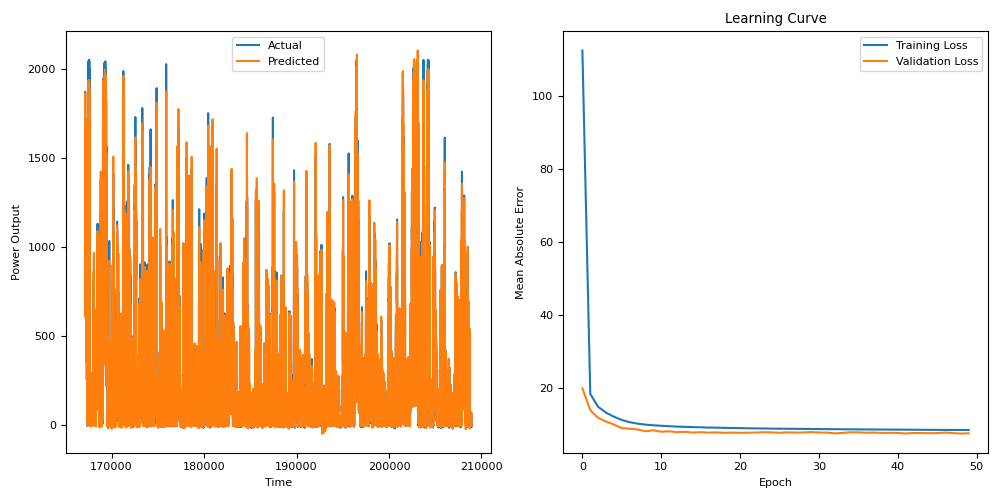

In [20]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(y_val, label='Actual')
plt.plot(y_val.index, y_val_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Power Output')
plt.legend()

# Plot learning curve
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve')
plt.legend()

plt.tight_layout()
plt.show()

From the learning curve we can see that the hyperparameters slightly improved the model. The gap between the traning and validation loss is smaller. This means that the model is able to generalize well on new, unseen data.

In [22]:
X_test = test_data
X_test_scaled = scaler.transform(X_test)

# Reshape the test data for LSTM input
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, n_features))

# Predict on the test set
prediction = model.predict(X_test_reshaped)

1633/1633 [==============================] - 1s 547us/step


## Comparing NN models

<IPython.core.display.Javascript object>


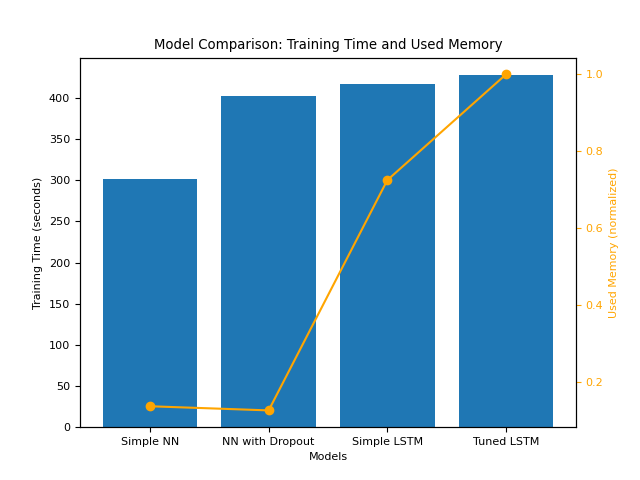

In [26]:
models = ['Simple NN', 'NN with Dropout', 'Simple LSTM', 'Tuned LSTM']
train_times = [simple_nn_train_time, dropout_nn_train_time, lstm_train_time, tuned_lstm_train_time]

# convert memory usage from Byte to MegaByte (MB = B/(1024**2))
mem_usage = [simple_nn_mem[0], dropout_nn_mem[0], lstm_mem[0], tuned_lstm_mem[0]]
mem_usage_mb = [mem/(1024**2) for mem in mem_usage]

# normalize the memory usage for better visualization
# it is used to make them comparable
max_mem_usage = max(mem_usage_mb)
memory_usage = [mem/max_mem_usage for mem in mem_usage_mb]

fig, ax1 = plt.subplots()

# Bar plot for training time
ax1.bar(models, train_times, label='Training Time (seconds)')
ax1.set_xlabel('Models')
ax1.set_ylabel('Training Time (seconds)')

# Create a secondary y-axis for used memory
ax2 = ax1.twinx()
ax2.plot(models, memory_usage, color='orange', marker='o', label='Used Memory (normalized)')
ax2.set_ylabel('Used Memory (normalized)', color='orange')
ax2.tick_params('y', colors='orange')

# Show the plot
plt.title('Model Comparison: Training Time and Used Memory')
plt.show()

We can see that training the LSTM takes more time than training the simple neural network. When looking at the memory usage we can see that when increasing the complexity the memory usage increases. This is because LSTMs have a special way of learning which enable them to better understand sequences but the complexity increases. This requires more resources.

## Submission

In [23]:
def generate_unique_filename(basename, file_ext):
    """Adds a timestamp to filenames for easier tracking of submissions, models, etc."""
    timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    return basename + '_' + timestamp + '.' + file_ext

In [24]:
submission = pd.DataFrame(data=prediction, columns=["active_power"])
submission.reset_index(inplace=True)
submission = submission.rename(columns = {'index':'id'})
submission.to_csv(generate_unique_filename("submission", "csv"), index=False)